In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Dateipfad (Rohstring vermeiden \-Fehler)
data_path = r"C:\Felix\Projektarbeit_f\Daten\Trainingsdaten"

# Dateien laden
df_lines = pd.read_parquet(f"{data_path}\\transaction_lines_train_2.parquet")
df_trans = pd.read_parquet(f"{data_path}\\transactions_train_2.parquet")
df_products = pd.read_csv(f"{data_path}\\products.csv")
df_stores = pd.read_csv(f"{data_path}\\stores.csv")

In [3]:
# Testdaten vorbereiten
test_data_path = r"C:\Felix\Projektarbeit_f\Daten\Testdaten"

df_lines_test = pd.read_parquet(f"{test_data_path}\\transaction_lines_test_2.parquet")
df_trans_test = pd.read_parquet(f"{test_data_path}\\transactions_test_2.parquet")

df_lines_test_merged = df_lines_test.merge(df_products, left_on="product_id", right_on="id", suffixes=('', '_product'))
df_lines_test_merged.drop(columns=["id_product", "base_product_id", "valid_from", "valid_to"], inplace=True)

df_features_test = df_lines_test_merged.groupby("transaction_id").agg({
    "sales_price": ["sum", "mean", "max"],
    "camera_certainty": ["mean", "min"],
    "was_voided": "sum",
    "category": pd.Series.nunique,
    "sold_by_weight": "sum",
    "age_restricted": "sum"
})
df_features_test.columns = ["_".join(col).strip() for col in df_features_test.columns.values]
df_features_test.reset_index(inplace=True)

df_model_test = df_trans_test.merge(df_features_test, left_on="id", right_on="transaction_id")
df_model_test = df_model_test.merge(df_stores, left_on="store_id", right_on="id", suffixes=('', '_store'))
df_model_test.drop(columns=["transaction_id", "id_store"], inplace=True)

# Speichern als CSV
df_model_test.to_csv(r"C:\Felix\Projektarbeit_f\Daten\Testdaten\df_model_test.csv", index=False)


In [4]:
# Alle DataFrames in ein Dictionary packen
dataframes = {
    "df_lines": df_lines,
    "df_trans": df_trans,
    "df_products": df_products,
    "df_stores": df_stores
}

# Für jeden DataFrame Info ausgeben
for name, df in dataframes.items():
    print(f"\n{'='*30}\n{name} – Übersicht\n{'='*30}")
    print(df.info())


df_lines – Übersicht
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16369776 entries, 0 to 16369775
Data columns (total 9 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   id                      int64         
 1   transaction_id          object        
 2   product_id              object        
 3   timestamp               datetime64[us]
 4   pieces_or_weight        float64       
 5   sales_price             float64       
 6   was_voided              bool          
 7   camera_product_similar  object        
 8   camera_certainty        float64       
dtypes: bool(1), datetime64[us](1), float64(3), int64(1), object(3)
memory usage: 1014.7+ MB
None

df_trans – Übersicht
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534158 entries, 0 to 1534157
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   id                 1534158 n

In [5]:
# Merge anhand product_id
df_lines_merged = df_lines.merge(df_products, left_on="product_id", right_on="id", suffixes=('', '_product'))

# Optional: Drop duplicate columns
df_lines_merged.drop(columns=["id_product", "base_product_id", "valid_from", "valid_to"], inplace=True)


In [6]:
# Beispielhafte Aggregationen auf Transaktionsebene
df_features = df_lines_merged.groupby("transaction_id").agg({
    "sales_price": ["sum", "mean", "max"],
    "camera_certainty": ["mean", "min"],
    "was_voided": "sum",
    "category": pd.Series.nunique,
    "sold_by_weight": "sum",
    "age_restricted": "sum"
})

# Spalten umbenennen
df_features.columns = ["_".join(col).strip() for col in df_features.columns.values]
df_features.reset_index(inplace=True)


In [7]:
# Merge aggregierte Features mit den Transaktionsdaten
df_model = df_trans.merge(df_features, left_on="id", right_on="transaction_id")

# Optional: Store-Infos anhängen
df_model = df_model.merge(df_stores, left_on="store_id", right_on="id", suffixes=('', '_store'))

# Drop überflüssige IDs
df_model.drop(columns=["transaction_id", "id_store"], inplace=True)


In [8]:
# Anzeige-Einstellungen anpassen
pd.set_option('display.max_columns', None)  # Alle Spalten anzeigen
pd.set_option('display.width', 0)            # Automatischer Zeilenumbruch deaktiviert
pd.set_option('display.expand_frame_repr', False)  # Horizontal scrollbar

# Die ersten 50 Zeilen ausgeben
df_model.head(5)


,id,store_id,cash_desk,transaction_start,transaction_end,total_amount,n_lines,payment_medium,customer_feedback,damage,label,sales_price_sum,sales_price_mean,sales_price_max,camera_certainty_mean,camera_certainty_min,was_voided_sum,category_nunique,sold_by_weight_sum,age_restricted_sum,opening_date,location,state,urbanization,sco_introduction
0,6373893b-fc7f-4a32-a1b6-71f7be4a098d,664c9b33-0553-4050-9dff-5afc3aa3334b,0,2022-02-14 08:07:12,2022-02-14 08:08:12.774160,98.19,8,CREDIT_CARD,NaN,NaN,UNKNOWN,98.19,12.273750,25.14,0.275345,0.242019,0,3,0,0,2006-06-19,Karlsruhe,Baden-Württemberg,TOWNS,2022-02-13
1,9a2badea-a77c-4cf9-a7fe-2b8cc1a371ba,664c9b33-0553-4050-9dff-5afc3aa3334b,1,2022-02-14 08:07:33,2022-02-14 08:07:56.951770,6.32,1,CREDIT_CARD,NaN,NaN,UNKNOWN,6.32,6.320000,6.32,0.291125,0.291125,0,1,0,0,2006-06-19,Karlsruhe,Baden-Württemberg,TOWNS,2022-02-13
2,1e5e4083-6f6a-4277-918d-ebb253ff8869,664c9b33-0553-4050-9dff-5afc3aa3334b,2,2022-02-14 08:10:42,2022-02-14 08:11:50.819448,96.57,14,CREDIT_CARD,NaN,0.0,NORMAL,96.57,6.897857,32.39,0.274696,0.185360,0,4,0,0,2006-06-19,Karlsruhe,Baden-Württemberg,TOWNS,2022-02-13
3,4a8fcf02-5d68-4138-8029-a493643e755d,664c9b33-0553-4050-9dff-5afc3aa3334b,3,2022-02-14 08:20:09,2022-02-14 08:20:52.679465,57.66,6,CREDIT_CARD,NaN,0.0,NORMAL,57.66,9.610000,34.11,0.281571,0.267869,0,3,0,0,2006-06-19,Karlsruhe,Baden-Württemberg,TOWNS,2022-02-13
4,43b984c7-43c2-411c-b862-d8d373f37891,664c9b33-0553-4050-9dff-5afc3aa3334b,1,2022-02-14 08:21:33,2022-02-14 08:24:40.911972,142.60,24,CREDIT_CARD,NaN,NaN,UNKNOWN,142.60,5.941667,23.80,0.279038,0.205506,0,3,0,0,2006-06-19,Karlsruhe,Baden-Württemberg,TOWNS,2022-02-13


In [9]:
# Verteilung der Labels zählen
label_counts = df_model['label'].value_counts()

# Prozentuale Verteilung berechnen
label_percent = (label_counts / len(df_model) * 100).round(2)

# Ausgabe
print("Anzahl der Labels:")
print(label_counts)

print("\nProzentuale Verteilung der Labels:")
print(label_percent)


Anzahl der Labels:
label
UNKNOWN    1381048
NORMAL      148318
FRAUD         4766
Name: count, dtype: int64

Prozentuale Verteilung der Labels:
label
UNKNOWN    90.02
NORMAL      9.67
FRAUD       0.31
Name: count, dtype: float64


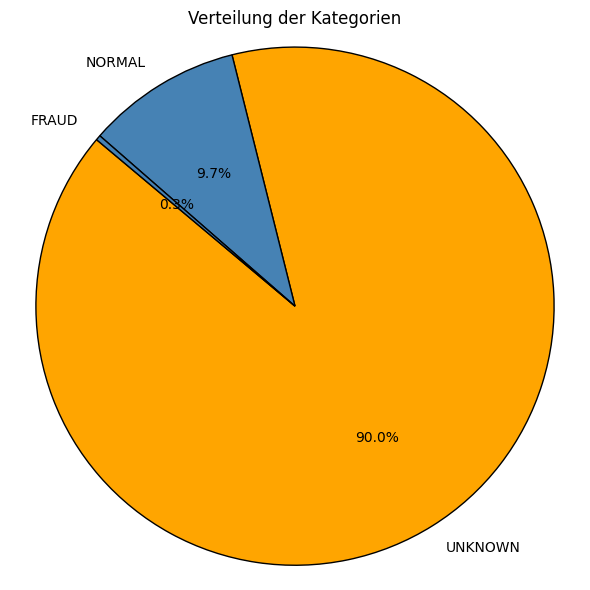

In [10]:
# Daten
labels = ['UNKNOWN', 'NORMAL', 'FRAUD']
values = [1381048, 148318, 4766]
colors = ['orange', 'steelblue', 'steelblue']

# Plot mit weißem Hintergrund
fig, ax = plt.subplots(figsize=(6, 6))
fig.patch.set_facecolor('white')  # Hintergrund des gesamten Plots
ax.set_facecolor('white')         # Hintergrund des Diagrammbereichs

wedges, texts, autotexts = ax.pie(
    values,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)

# Textfarben anpassen (jetzt schwarz auf weißem Hintergrund)
for text in texts + autotexts:
    text.set_color('black')

# Titel
plt.title('Verteilung der Kategorien', color='black')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [11]:
# Für jedes Label separat die fehlenden Werte zählen
for label in df_model['label'].unique():
    print(f"\nFehlende Werte für Label: {label}")
    
    # Nur Zeilen mit diesem Label auswählen
    subset = df_model[df_model['label'] == label]
    
    # Fehlende Werte in diesem Subset
    missing = subset.isnull().sum()
    
    # Nur Spalten mit mindestens 1 fehlendem Wert anzeigen
    missing = missing[missing > 0]
    
    if missing.empty:
        print("Keine fehlenden Werte.")
    else:
        print(missing)



Fehlende Werte für Label: UNKNOWN
customer_feedback        1282542
damage                   1381048
camera_certainty_mean        967
camera_certainty_min         967
dtype: int64

Fehlende Werte für Label: NORMAL
customer_feedback        137684
camera_certainty_mean       105
camera_certainty_min        105
dtype: int64

Fehlende Werte für Label: FRAUD
customer_feedback        4422
camera_certainty_mean       8
camera_certainty_min        8
dtype: int64


In [12]:
# Alle fehlenden Werte in der Modell-Tabelle anzeigen
missing_values = df_model.isnull().sum()

In [13]:
# Nur Spalten zeigen, wo es wirklich fehlende Werte gibt
missing_values = missing_values[missing_values > 0]

In [14]:
# Ausgabe
print("Fehlende Werte pro Spalte:")
print(missing_values)

Fehlende Werte pro Spalte:
customer_feedback        1424648
damage                   1381048
camera_certainty_mean       1080
camera_certainty_min        1080
dtype: int64


In [15]:
# Spalte entfernen
df_model.drop(columns=['customer_feedback'], inplace=True)


In [16]:
# Nur Zeilen behalten, wo Label bekannt ist (NORMAL oder FRAUD)
df_model_labeled = df_model[df_model['label'].isin(['NORMAL', 'FRAUD'])].copy()

# Ergebnis anzeigen
print(f"Übrig gebliebene Zeilen: {len(df_model_labeled)}")
print(df_model_labeled['label'].value_counts())

# Anzahl der Zeilen der gefilterten Tabelle ausgeben
print(f"Anzahl der Zeilen nach Entfernen von UNKNOWN Labels: {len(df_model_labeled)}")


Übrig gebliebene Zeilen: 153084
label
NORMAL    148318
FRAUD       4766
Name: count, dtype: int64
Anzahl der Zeilen nach Entfernen von UNKNOWN Labels: 153084


In [17]:
# Speichern der DataFrames als CSV in den Zielordner
df_model_labeled.to_csv(r"C:\Felix\Projektarbeit_f\Daten\Pipline\df_model_ready.csv", index=False)

In [18]:
df_trans_sample = df_model_labeled.head(100)

In [19]:
df_trans_sample.to_csv(r"C:\Felix\Projektarbeit_f\Daten\gekürzt\model_labeld.csv", index=False)

In [20]:
# Alle relevanten Transaktions-IDs aus df_model_labeled holen (nur NORMAL + FRAUD)
valid_ids = df_model_labeled['id'].unique()

# Artikelzeilen mit diesen IDs filtern
filtered_lines = df_lines_merged[df_lines_merged['transaction_id'].isin(valid_ids)]

# Jetzt Kategoriehäufigkeiten auf Artikelbasis
category_counts = filtered_lines['category'].value_counts()

# wie oft wurde ein Artikel aus dieser Kategorie bei den Gelabelten daten gekauft
print("Artikelanzahl pro Kategorie (nur in gelabelten Transaktionen):")
print(category_counts)


Artikelanzahl pro Kategorie (nur in gelabelten Transaktionen):
category
FRUITS_VEGETABLES_PIECES    761856
BEVERAGES                   425072
DAIRY                       139633
FROZEN_GOODS                133654
LONG_SHELF_LIFE              68336
CONVENIENCE                  63743
PERSONAL_CARE                15474
HOUSEHOLD                     6406
FRUITS_VEGETABLES             4090
SNACKS                        3410
ALCOHOL                       2639
BAKERY                        2133
TOBACCO                        913
LIMITED_TIME_OFFERS              1
Name: count, dtype: int64


In [21]:
# Gruppiere nach Transaktion und hole die eindeutigen Kategorien
trans_category = filtered_lines.groupby('transaction_id')['category'].unique()

# Alle Kategorien aus allen Transaktionen zusammenzählen
from collections import Counter
all_cats = Counter([cat for cats in trans_category for cat in cats])

# In DataFrame umwandeln
category_transaction_counts = pd.DataFrame.from_dict(all_cats, orient='index', columns=['Anzahl Transaktionen']).sort_values(by='Anzahl Transaktionen', ascending=False)

# Wie oft wurde mindestens ein artikel aus dieser kategorie pro einkauf (transaktion) gekauf
print("Wie oft kam eine Kategorie in Transaktionen vor:")
print(category_transaction_counts)


Wie oft kam eine Kategorie in Transaktionen vor:
                          Anzahl Transaktionen
FRUITS_VEGETABLES_PIECES                129620
BEVERAGES                               106118
FROZEN_GOODS                             62420
DAIRY                                    43071
LONG_SHELF_LIFE                          37109
CONVENIENCE                              27730
PERSONAL_CARE                            12205
HOUSEHOLD                                 5700
FRUITS_VEGETABLES                         3630
SNACKS                                    3293
ALCOHOL                                   2496
BAKERY                                    2100
TOBACCO                                    888
LIMITED_TIME_OFFERS                          1


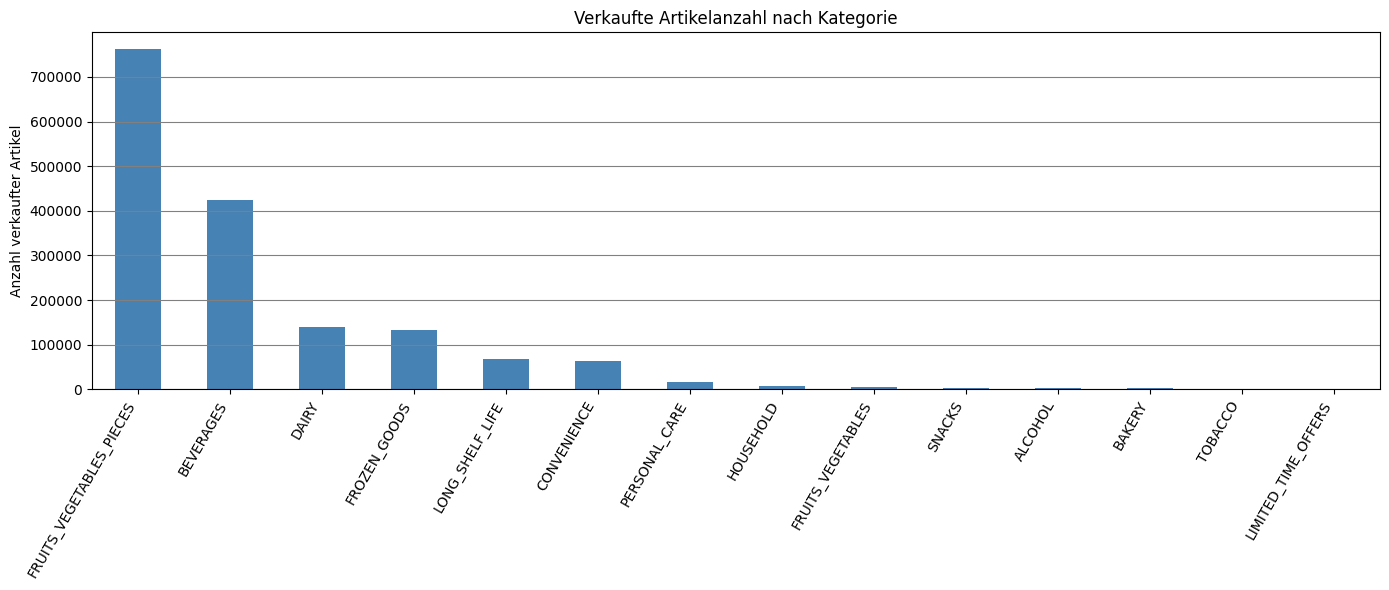

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Werte aus deiner Liste
category_counts = {
    'FRUITS_VEGETABLES_PIECES': 761856,
    'BEVERAGES': 425072,
    'DAIRY': 139633,
    'FROZEN_GOODS': 133654,
    'LONG_SHELF_LIFE': 68336,
    'CONVENIENCE': 63743,
    'PERSONAL_CARE': 15474,
    'HOUSEHOLD': 6406,
    'FRUITS_VEGETABLES': 4090,
    'SNACKS': 3410,
    'ALCOHOL': 2639,
    'BAKERY': 2133,
    'TOBACCO': 913,
    'LIMITED_TIME_OFFERS': 1
}

# DataFrame erstellen und sortieren
df = pd.DataFrame.from_dict(category_counts, orient='index', columns=['Anzahl'])
df = df.sort_values('Anzahl', ascending=False)

# Plot mit weißem Hintergrund
fig, ax = plt.subplots(figsize=(14, 6))  # Etwas breiter
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

df.plot(kind='bar', legend=False, color='steelblue', ax=ax)

# Achsen & Titel
ax.set_ylabel('Anzahl verkaufter Artikel', color='black')
ax.set_title('Verkaufte Artikelanzahl nach Kategorie', color='black')

# Verbessere x-Achsen-Ticks
plt.xticks(rotation=60, ha='right', color='black')  # saubere Ausrichtung
ax.tick_params(axis='y', colors='black')
ax.grid(axis='y', color='gray')

plt.tight_layout()
plt.show()



In [23]:
# IDs von FRAUD- und NORMAL-Transaktionen separat
fraud_ids = df_model_labeled[df_model_labeled['label'] == 'FRAUD']['id'].unique()
normal_ids = df_model_labeled[df_model_labeled['label'] == 'NORMAL']['id'].unique()

# Gefilterte Artikelzeilen holen
fraud_lines = df_lines_merged[df_lines_merged['transaction_id'].isin(fraud_ids)]
normal_lines = df_lines_merged[df_lines_merged['transaction_id'].isin(normal_ids)]


In [24]:
# Kategorien nach Anzahl verkaufter Artikel zählen
fraud_category_counts = fraud_lines['category'].value_counts()
normal_category_counts = normal_lines['category'].value_counts()

# Zusammenführen für Vergleich
category_compare = pd.DataFrame({
    'Fraud_Artikelanzahl': fraud_category_counts,
    'Normal_Artikelanzahl': normal_category_counts
}).fillna(0).astype(int)

# Verhältnis Fraud zu Normal ausrechnen
category_compare['Fraud_vs_Normal (%)'] = (category_compare['Fraud_Artikelanzahl'] / (category_compare['Normal_Artikelanzahl'] + 1) * 100).round(2)

print(category_compare)


                          Fraud_Artikelanzahl  Normal_Artikelanzahl  Fraud_vs_Normal (%)
category                                                                                
ALCOHOL                                    37                  2602                 1.42
BAKERY                                     79                  2054                 3.84
BEVERAGES                               14140                410932                 3.44
CONVENIENCE                              2425                 61318                 3.95
DAIRY                                    5461                134172                 4.07
FROZEN_GOODS                             3986                129668                 3.07
FRUITS_VEGETABLES                         179                  3911                 4.58
FRUITS_VEGETABLES_PIECES                25408                736448                 3.45
HOUSEHOLD                                 221                  6185                 3.57
LIMITED_TIME_OFFERS  

In [25]:
df.plot(kind='barh', legend=False, color='skyblue', ax=ax)
ax.set_xlabel('Fraud (%)', color='black')
ax.set_ylabel('Kategorie', color='black')


Text(24.0, 0.5, 'Kategorie')

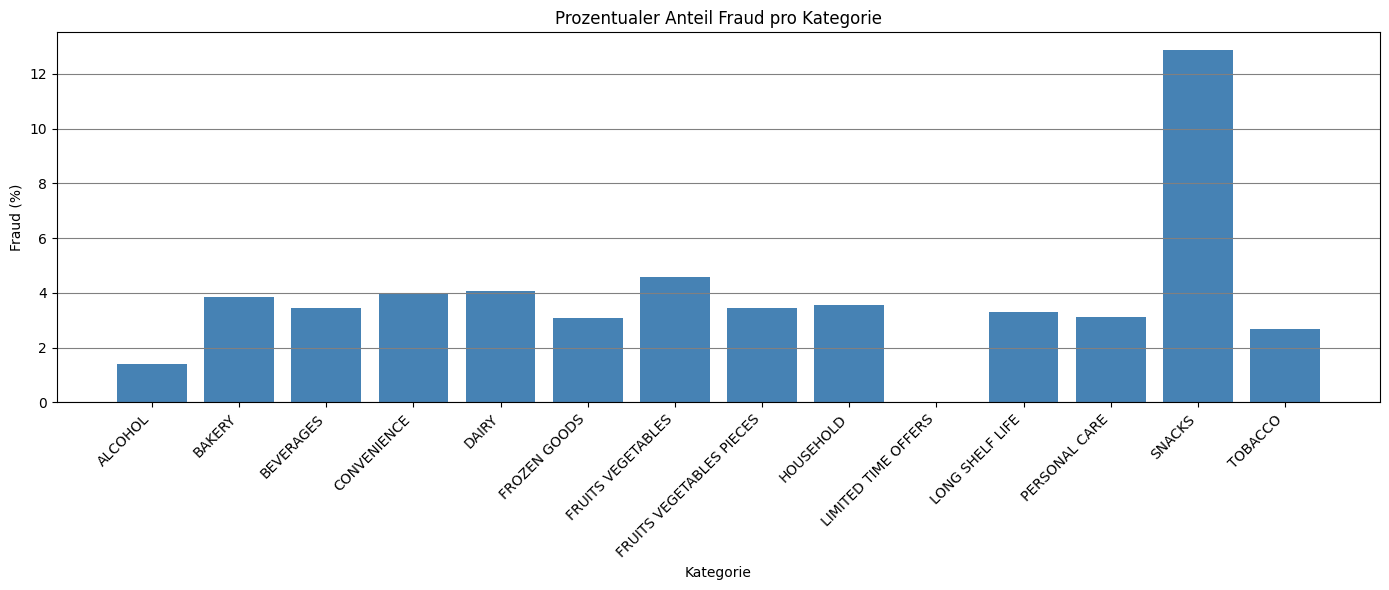

In [26]:
#  Daten vorbereiten
data = {
    'category': [
        'ALCOHOL', 'BAKERY', 'BEVERAGES', 'CONVENIENCE', 'DAIRY', 'FROZEN GOODS',
        'FRUITS VEGETABLES', 'FRUITS VEGETABLES PIECES', 'HOUSEHOLD',
        'LIMITED TIME OFFERS', 'LONG SHELF LIFE', 'PERSONAL CARE', 'SNACKS', 'TOBACCO'
    ],
    'Fraud_vs_Normal (%)': [
        1.42, 3.84, 3.44, 3.95, 4.07, 3.07, 4.58, 3.45, 3.57, 0.00,
        3.30, 3.12, 12.87, 2.70
    ]
}

# DataFrame erstellen
df = pd.DataFrame(data)

# Plot
fig, ax = plt.subplots(figsize=(14, 6))  # Etwas breiter für lange Kategorien
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

bars = ax.bar(df['category'], df['Fraud_vs_Normal (%)'], color='steelblue')

# Achsentitel & Formatierung
ax.set_ylabel('Fraud (%)', color='black')
ax.set_xlabel('Kategorie', color='black')
ax.set_title('Prozentualer Anteil Fraud pro Kategorie', color='black')

# Gut lesbare Beschriftung der X-Achse
plt.xticks(rotation=45, ha='right', color='black')
ax.tick_params(axis='y', colors='black')

# Gitter
ax.grid(axis='y', color='gray')

plt.tight_layout()
plt.show()

In [27]:
# Festlegen der 3 riskantesten Kategorien
top_risky_categories = ['SNACKS', 'BEVERAGES', 'FROZEN_GOODS']

# WICHTIG: Eine Kopie von filtered_lines erzeugen, um die SettingWithCopyWarning zu vermeiden
filtered_lines = filtered_lines.copy()

# Für jede der 3 Kategorien ein neues Feature erstellen
for cat in top_risky_categories:
    feature_name = f'has_{cat.lower()}'
    filtered_lines[feature_name] = (filtered_lines['category'] == cat).astype(int)

# Pro Transaktion aggregieren: Hat diese Transaktion mindestens einen Artikel aus der Kategorie?
risky_features_per_cat = filtered_lines.groupby('transaction_id').agg({
    'has_snacks': 'max',
    'has_beverages': 'max',
    'has_frozen_goods': 'max'
}).reset_index()

# Merge zurück auf df_model_labeled
df_model_labeled = df_model_labeled.merge(risky_features_per_cat, left_on='id', right_on='transaction_id', how='left')

# transaction_id-Spalte löschen, weil sie redundant ist
df_model_labeled.drop(columns=['transaction_id'], inplace=True)

In [28]:
# 1. Gewichtungen pro Kategorie definieren
category_weights = {
    'has_snacks': 3,         # Snacks am riskantesten → Gewicht 3
    'has_beverages': 2,      # Beverages mittleres Risiko → Gewicht 2
    'has_frozen_goods': 1     # Frozen Goods geringeres Risiko → Gewicht 1
}

# 2. Neue Feature-Spalte 'risky_category_score' erstellen
df_model_labeled['risky_category_score'] = (
    df_model_labeled['has_snacks'] * category_weights['has_snacks'] +
    df_model_labeled['has_beverages'] * category_weights['has_beverages'] +
    df_model_labeled['has_frozen_goods'] * category_weights['has_frozen_goods']
)

# 3. Ausgabe zur Kontrolle
print(df_model_labeled[['has_snacks', 'has_beverages', 'has_frozen_goods', 'risky_category_score']].head())


   has_snacks  has_beverages  has_frozen_goods  risky_category_score
0           0              1                 1                     3
1           0              1                 1                     3
2           0              1                 0                     2
3           0              1                 0                     2
4           0              0                 1                     1


In [29]:
# Sicherstellen, dass die Zeitspalten im Datetime-Format sind
df_model_labeled['transaction_start'] = pd.to_datetime(df_model_labeled['transaction_start'])
df_model_labeled['transaction_end'] = pd.to_datetime(df_model_labeled['transaction_end'])

# Neue Spalte: Transaktionsdauer in Sekunden
df_model_labeled['transaction_duration_seconds'] = (df_model_labeled['transaction_end'] - df_model_labeled['transaction_start']).dt.total_seconds()

# Ausgabe zur Kontrolle
print(df_model_labeled[['transaction_start', 'transaction_end', 'transaction_duration_seconds']].head())


    transaction_start            transaction_end  transaction_duration_seconds
0 2022-02-14 08:10:42 2022-02-14 08:11:50.819448                     68.819448
1 2022-02-14 08:20:09 2022-02-14 08:20:52.679465                     43.679465
2 2022-02-14 08:42:12 2022-02-14 08:42:42.023526                     30.023526
3 2022-02-14 09:02:09 2022-02-14 09:02:36.613637                     27.613637
4 2022-02-14 09:09:30 2022-02-14 09:10:20.716049                     50.716049


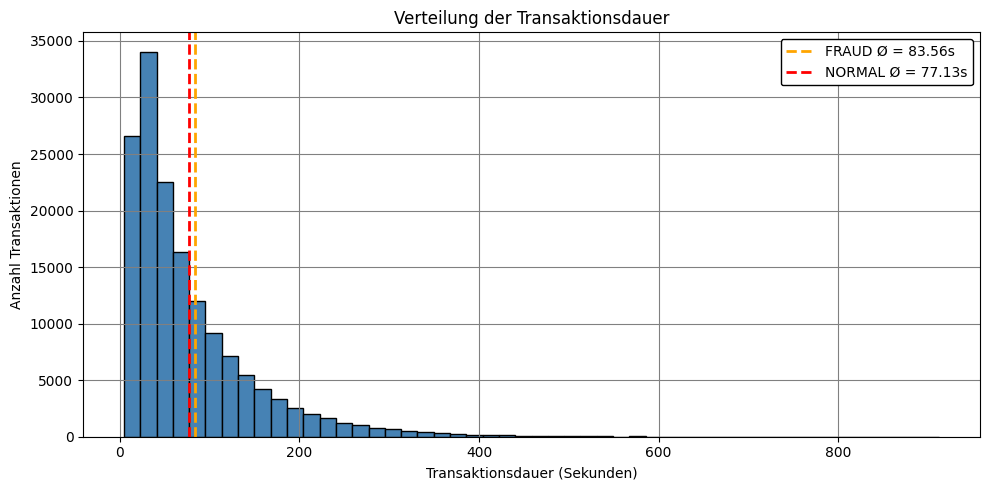

In [30]:
# Durchschnittswerte
fraud_avg = 83.560904
normal_avg = 77.132802

# Plot mit weißem Hintergrund
fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Histogramm
ax.hist(
    df_model_labeled['transaction_duration_seconds'],
    bins=50,
    color='steelblue',
    edgecolor='black'
)

# Durchschnittslinien
ax.axvline(fraud_avg, color='orange', linestyle='--', linewidth=2, label=f'FRAUD Ø = {fraud_avg:.2f}s')
ax.axvline(normal_avg, color='red', linestyle='--', linewidth=2, label=f'NORMAL Ø = {normal_avg:.2f}s')

# Achsen & Titel
ax.set_xlabel('Transaktionsdauer (Sekunden)', color='black')
ax.set_ylabel('Anzahl Transaktionen', color='black')
ax.set_title('Verteilung der Transaktionsdauer', color='black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.grid(True, color='gray')

# Helle Legende
legend = ax.legend(facecolor='white', edgecolor='black', framealpha=1)
for text in legend.get_texts():
    text.set_color('black')

plt.tight_layout()
plt.show()

In [31]:
# Durchschnittliche Dauer pro Label
duration_by_label = df_model_labeled.groupby('label')['transaction_duration_seconds'].mean()

print("\nDurchschnittliche Transaktionsdauer je Label:")
print(duration_by_label)



Durchschnittliche Transaktionsdauer je Label:
label
FRAUD     83.560904
NORMAL    77.132802
Name: transaction_duration_seconds, dtype: float64


In [32]:
# Feature 1: Transaktionsdauer in Sekunden ist schon da

# Feature 2: Artikel pro Minute
# Voraussetzung: n_lines = Anzahl der Artikel pro Transaktion
df_model_labeled['articles_per_minute'] = (df_model_labeled['n_lines'] / (df_model_labeled['transaction_duration_seconds'] / 60)).round(2)

# Ausgabe zur Kontrolle
print(df_model_labeled[['transaction_duration_seconds', 'n_lines', 'articles_per_minute']].head())


   transaction_duration_seconds  n_lines  articles_per_minute
0                     68.819448       14                12.21
1                     43.679465        6                 8.24
2                     30.023526        3                 6.00
3                     27.613637        3                 6.52
4                     50.716049        6                 7.10


In [33]:
avg_apm = df_model_labeled.groupby('label')['articles_per_minute'].mean().round(2)
print("Durchschnittliche Artikel pro Minute:")
print(avg_apm)


Durchschnittliche Artikel pro Minute:
label
FRAUD     7.60
NORMAL    7.73
Name: articles_per_minute, dtype: float64


In [34]:
# Separate Daten für FRAUD und NORMAL
fraud_data = df_model_labeled[df_model_labeled['label'] == 'FRAUD']['articles_per_minute']
normal_data = df_model_labeled[df_model_labeled['label'] == 'NORMAL']['articles_per_minute']


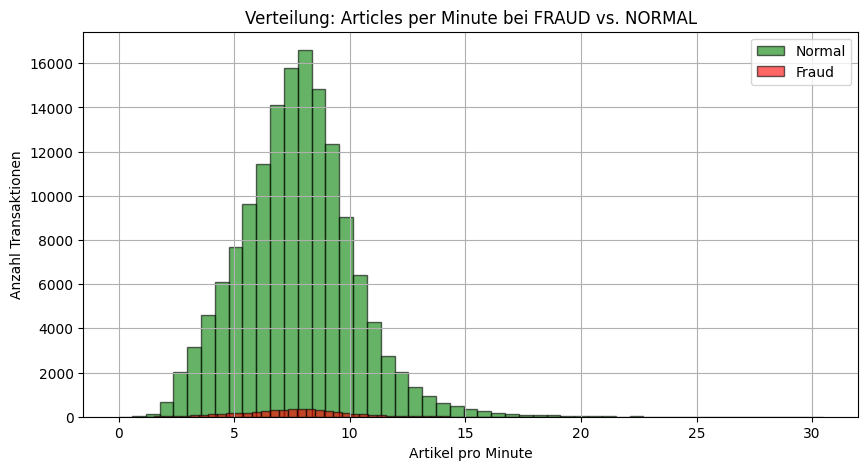

In [35]:
# Plot: Überlagerte Histogramme
plt.figure(figsize=(10, 5))
plt.hist(normal_data, bins=50, alpha=0.6, label='Normal', color='green', edgecolor='black')
plt.hist(fraud_data, bins=50, alpha=0.6, label='Fraud', color='red', edgecolor='black')
plt.xlabel('Artikel pro Minute')
plt.ylabel('Anzahl Transaktionen')
plt.title('Verteilung: Articles per Minute bei FRAUD vs. NORMAL')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
# Kontrollieren: gibt es die Spalte schon?
print('total_amount' in df_model_labeled.columns)



True


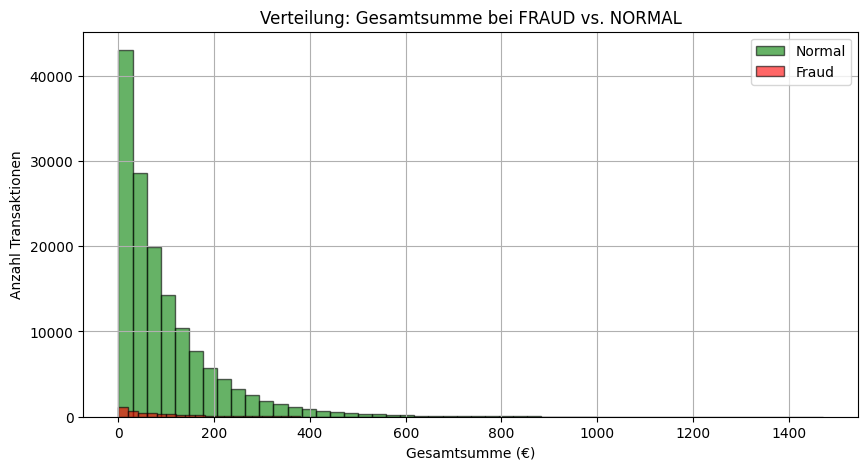


Durchschnittliche Gesamtsumme je Label:
label
FRAUD     100.767360
NORMAL     98.154747
Name: total_amount, dtype: float64


In [37]:
# Plot: Verteilung der Gesamtsummen
fraud_total = df_model_labeled[df_model_labeled['label'] == 'FRAUD']['total_amount']
normal_total = df_model_labeled[df_model_labeled['label'] == 'NORMAL']['total_amount']

plt.figure(figsize=(10, 5))
plt.hist(normal_total, bins=50, alpha=0.6, label='Normal', color='green', edgecolor='black')
plt.hist(fraud_total, bins=50, alpha=0.6, label='Fraud', color='red', edgecolor='black')
plt.xlabel('Gesamtsumme (€)')
plt.ylabel('Anzahl Transaktionen')
plt.title('Verteilung: Gesamtsumme bei FRAUD vs. NORMAL')
plt.legend()
plt.grid(True)
plt.show()

# Durchschnittliche Gesamtsumme je Label
avg_total_amount = df_model_labeled.groupby('label')['total_amount'].mean()

print("\nDurchschnittliche Gesamtsumme je Label:")
print(avg_total_amount)

In [38]:
# Maximum sales_price aus Artikelzeilen bei FRAUD-Transaktionen
fraud_ids = df_model_labeled[df_model_labeled['label'] == 'FRAUD']['id'].unique()

# Gehe in die Artikelzeilen (df_lines_merged) und filtere nur auf FRAUD-Transaktionen
fraud_articles = df_lines_merged[df_lines_merged['transaction_id'].isin(fraud_ids)]

# Teuerster Artikel bei FRAUD
max_price_fraud = fraud_articles['sales_price'].max()

print(f"Teuerster Artikelpreis bei FRAUD: {max_price_fraud} €")


Teuerster Artikelpreis bei FRAUD: 155.03 €


In [39]:
# Neues Feature: Durchschnittlicher Preis pro Artikel
df_model_labeled['average_price_per_article'] = (df_model_labeled['total_amount'] / df_model_labeled['n_lines']).round(2)

# Ausgabe zur Kontrolle
print(df_model_labeled[['total_amount', 'n_lines', 'average_price_per_article']].head())


   total_amount  n_lines  average_price_per_article
0         96.57       14                       6.90
1         57.66        6                       9.61
2         12.20        3                       4.07
3         41.34        3                      13.78
4         57.41        6                       9.57


In [40]:
# Neues Feature bauen, falls noch nicht erstellt
df_model_labeled['average_price_per_article'] = (df_model_labeled['total_amount'] / df_model_labeled['n_lines']).round(2)

# Durchschnittlicher Durchschnittspreis je Label
avg_price_per_article = df_model_labeled.groupby('label')['average_price_per_article'].mean()

print("\nDurchschnittlicher Artikelpreis je Label:")
print(avg_price_per_article)



Durchschnittlicher Artikelpreis je Label:
label
FRAUD     8.241204
NORMAL    9.576955
Name: average_price_per_article, dtype: float64


In [41]:
avg_n_lines = df_model_labeled.groupby('label')['n_lines'].mean().round(2)

print("Durchschnittliche Anzahl Artikel je Transaktion:")
print(avg_n_lines)


Durchschnittliche Anzahl Artikel je Transaktion:
label
FRAUD     11.41
NORMAL    10.52
Name: n_lines, dtype: float64


In [42]:
# Gesamte Verteilung der Zahlungsmethoden
payment_distribution = df_model_labeled['payment_medium'].value_counts()

print("Zahlungsmethoden gesamt:")
print(payment_distribution)


Zahlungsmethoden gesamt:
payment_medium
CREDIT_CARD    137572
CASH            15512
Name: count, dtype: int64


In [43]:
# Verteilung der Zahlungsmethoden bei NORMAL und FRAUD
payment_by_label = df_model_labeled.groupby('label')['payment_medium'].value_counts(normalize=True).unstack().round(3)

print("\nVerteilung der Zahlungsmethoden je Label (Anteil):")
print(payment_by_label)



Verteilung der Zahlungsmethoden je Label (Anteil):
payment_medium   CASH  CREDIT_CARD
label                             
FRAUD           0.656        0.344
NORMAL          0.084        0.916


In [44]:
# Neues Feature: Hat Bar bezahlt
df_model_labeled['has_cash_payment'] = (df_model_labeled['payment_medium'] == 'CASH').astype(int)

# Kontrolle
print(df_model_labeled[['payment_medium', 'has_cash_payment']].head())


  payment_medium  has_cash_payment
0    CREDIT_CARD                 0
1    CREDIT_CARD                 0
2    CREDIT_CARD                 0
3    CREDIT_CARD                 0
4    CREDIT_CARD                 0


In [45]:
# Neues Flag: Wurde ein Artikel storniert? (1 = storniert, 0 = normal verkauft)
# Annahme: Es gibt eine Spalte 'voided' oder ähnliches, die das markiert.
# Falls 'voided' als Spalte existiert:
filtered_lines['is_voided'] = filtered_lines['was_voided'].astype(int)

# Anzahl der stornierten Artikel pro Transaktion zählen
voided_per_transaction = filtered_lines.groupby('transaction_id')['is_voided'].sum().reset_index()
voided_per_transaction.rename(columns={'is_voided': 'voided_articles_count'}, inplace=True)


In [46]:
# Merge voided_counts auf df_model_labeled
df_model_labeled = df_model_labeled.merge(voided_per_transaction, left_on='id', right_on='transaction_id', how='left')

# Fehlende Werte (Transaktionen ohne Stornos) auf 0 setzen
df_model_labeled['voided_articles_count'] = df_model_labeled['voided_articles_count'].fillna(0).astype(int)

# transaction_id wieder droppen (redundant)
df_model_labeled.drop(columns=['transaction_id'], inplace=True)


In [47]:
# Neues Feature: Anteil stornierter Artikel
df_model_labeled['voided_articles_ratio'] = (df_model_labeled['voided_articles_count'] / df_model_labeled['n_lines']).round(3)

# Kontrolle
print(df_model_labeled[['n_lines', 'voided_articles_count', 'voided_articles_ratio']].head())


   n_lines  voided_articles_count  voided_articles_ratio
0       14                      0                    0.0
1        6                      0                    0.0
2        3                      0                    0.0
3        3                      0                    0.0
4        6                      0                    0.0


In [48]:
# Durchschnittliche Anzahl stornierter Artikel je Label
avg_voided_count = df_model_labeled.groupby('label')['voided_articles_count'].mean()

# Durchschnittlicher Anteil stornierter Artikel je Label
avg_voided_ratio = df_model_labeled.groupby('label')['voided_articles_ratio'].mean()

print("\nDurchschnittliche Anzahl stornierter Artikel je Label:")
print(avg_voided_count)

print("\nDurchschnittlicher Anteil stornierter Artikel je Label:")
print(avg_voided_ratio)



Durchschnittliche Anzahl stornierter Artikel je Label:
label
FRAUD     0.125472
NORMAL    0.078588
Name: voided_articles_count, dtype: float64

Durchschnittlicher Anteil stornierter Artikel je Label:
label
FRAUD          inf
NORMAL    0.007856
Name: voided_articles_ratio, dtype: float64


In [49]:
# Neue Berechnung der voided_articles_ratio, nur für n_lines > 0
df_model_labeled['voided_articles_ratio'] = df_model_labeled.apply(
    lambda x: x['voided_articles_count'] / x['n_lines'] if x['n_lines'] > 0 else 0,
    axis=1
).round(3)

# Danach nochmal neu berechnen:
avg_voided_ratio = df_model_labeled.groupby('label')['voided_articles_ratio'].mean()

print("\nNeuer durchschnittlicher Anteil stornierter Artikel je Label:")
print(avg_voided_ratio)



Neuer durchschnittlicher Anteil stornierter Artikel je Label:
label
FRAUD     0.019933
NORMAL    0.007856
Name: voided_articles_ratio, dtype: float64


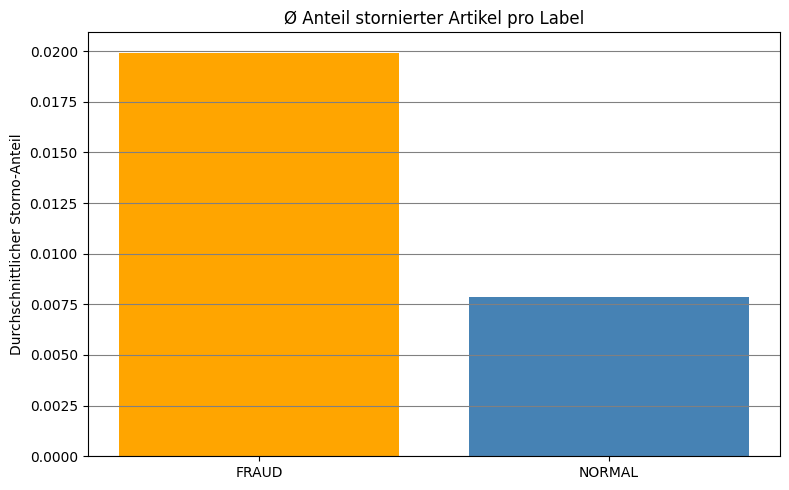

In [50]:

# Daten
data = {
    'label': ['FRAUD', 'NORMAL'],
    'storno_anteil': [0.019933, 0.007856]
}
df = pd.DataFrame(data)

# Plot mit weißem Hintergrund
fig, ax = plt.subplots(figsize=(8, 5))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Farben definieren
colors = ['orange' if label == 'FRAUD' else 'steelblue' for label in df['label']]

# Balkendiagramm
bars = ax.bar(df['label'], df['storno_anteil'], color=colors)

# Beschriftung & Stil
ax.set_ylabel('Durchschnittlicher Storno-Anteil', color='black')
ax.set_title('Ø Anteil stornierter Artikel pro Label', color='black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.grid(axis='y', color='gray')

plt.tight_layout()
plt.show()

In [51]:
# Neues Flag-Feature: Hat die Transaktion mehr als 10% stornierte Artikel?
df_model_labeled['has_high_voided_ratio'] = (df_model_labeled['voided_articles_ratio'] > 0.1).astype(int)

# Kontrolle
print(df_model_labeled[['voided_articles_count', 'n_lines', 'voided_articles_ratio', 'has_high_voided_ratio']].head())


   voided_articles_count  n_lines  voided_articles_ratio  has_high_voided_ratio
0                      0       14                    0.0                      0
1                      0        6                    0.0                      0
2                      0        3                    0.0                      0
3                      0        3                    0.0                      0
4                      0        6                    0.0                      0


In [52]:
# 1. Verteilung des Flags insgesamt
high_voided_distribution = df_model_labeled['has_high_voided_ratio'].value_counts(normalize=True).round(3) * 100

print("\nVerteilung 'has_high_voided_ratio' (in Prozent):")
print(high_voided_distribution)

# 2. Verteilung des Flags getrennt nach Label (FRAUD vs. NORMAL)
high_voided_by_label = df_model_labeled.groupby('label')['has_high_voided_ratio'].value_counts(normalize=True).unstack().round(3) * 100

print("\nVerteilung 'has_high_voided_ratio' je Label (in Prozent):")
print(high_voided_by_label)



Verteilung 'has_high_voided_ratio' (in Prozent):
has_high_voided_ratio
0    97.8
1     2.2
Name: proportion, dtype: float64

Verteilung 'has_high_voided_ratio' je Label (in Prozent):
has_high_voided_ratio     0    1
label                           
FRAUD                  95.0  5.0
NORMAL                 97.9  2.1


In [53]:
# 1. Durchschnittlicher camera_certainty_mean je Label
avg_camera_certainty_mean = df_model_labeled.groupby('label')['camera_certainty_mean'].mean()

# 2. Durchschnittlicher camera_certainty_min je Label
avg_camera_certainty_min = df_model_labeled.groupby('label')['camera_certainty_min'].mean()

print("\nDurchschnittliche camera_certainty_mean je Label:")
print(avg_camera_certainty_mean)

print("\nDurchschnittliche camera_certainty_min je Label:")
print(avg_camera_certainty_min)



Durchschnittliche camera_certainty_mean je Label:
label
FRAUD     0.890624
NORMAL    0.897530
Name: camera_certainty_mean, dtype: float64

Durchschnittliche camera_certainty_min je Label:
label
FRAUD     0.69252
NORMAL    0.70927
Name: camera_certainty_min, dtype: float64


In [54]:
# 1. Neues temporäres Flag erstellen (nur zur Analyse)
df_model_labeled['low_camera_certainty_flag'] = (df_model_labeled['camera_certainty_min'] < 0.6).astype(int)

# 2. Verteilung insgesamt (wie oft kommt das Flag vor?)
low_certainty_overall = df_model_labeled['low_camera_certainty_flag'].value_counts(normalize=True).round(3) * 100

print("\nVerteilung low_camera_certainty_flag (gesamt, in %):")
print(low_certainty_overall)

# 3. Verteilung je Label (FRAUD vs. NORMAL)
low_certainty_by_label = df_model_labeled.groupby('label')['low_camera_certainty_flag'].value_counts(normalize=True).unstack().round(3) * 100

print("\nVerteilung low_camera_certainty_flag je Label (in %):")
print(low_certainty_by_label)



Verteilung low_camera_certainty_flag (gesamt, in %):
low_camera_certainty_flag
0    69.9
1    30.1
Name: proportion, dtype: float64

Verteilung low_camera_certainty_flag je Label (in %):
low_camera_certainty_flag     0     1
label                                
FRAUD                      67.8  32.2
NORMAL                     70.0  30.0


In [55]:
# Neues Flag setzen: Kamera-Erkennung unter 30%
df_model_labeled['low_camera_certainty_flag'] = (df_model_labeled['camera_certainty_min'] < 0.23).astype(int)

# Verteilung anschauen: wie viele 0 und 1
flag_distribution = df_model_labeled['low_camera_certainty_flag'].value_counts()
flag_distribution_percent = df_model_labeled['low_camera_certainty_flag'].value_counts(normalize=True).round(3) * 100

print("\nAnzahl der gesetzten Flags (gesamt):")
print(flag_distribution)

print("\nProzentuale Verteilung der Flags (gesamt):")
print(flag_distribution_percent)

# Verteilung des Flags je Label (FRAUD vs. NORMAL) in absoluten Zahlen
flag_by_label = df_model_labeled.groupby('label')['low_camera_certainty_flag'].value_counts().unstack().fillna(0).astype(int)

print("\nVerteilung der Flags je Label (Anzahl):")
print(flag_by_label)

# Verteilung des Flags je Label (FRAUD vs. NORMAL) in Prozent
flag_by_label_percent = df_model_labeled.groupby('label')['low_camera_certainty_flag'].value_counts(normalize=True).unstack().round(3) * 100

print("\nVerteilung der Flags je Label (Prozent):")
print(flag_by_label_percent)



Anzahl der gesetzten Flags (gesamt):
low_camera_certainty_flag
0    152707
1       377
Name: count, dtype: int64

Prozentuale Verteilung der Flags (gesamt):
low_camera_certainty_flag
0    99.8
1     0.2
Name: proportion, dtype: float64

Verteilung der Flags je Label (Anzahl):
low_camera_certainty_flag       0    1
label                                 
FRAUD                        4715   51
NORMAL                     147992  326

Verteilung der Flags je Label (Prozent):
low_camera_certainty_flag     0    1
label                               
FRAUD                      98.9  1.1
NORMAL                     99.8  0.2


In [56]:
# 1. Sicherstellen, dass transaction_start im datetime-Format ist
df_model_labeled['transaction_start'] = pd.to_datetime(df_model_labeled['transaction_start'])



In [57]:
# 2. Neue Spalte: Stunde extrahieren
df_model_labeled['hour'] = df_model_labeled['transaction_start'].dt.hour



In [58]:
# 3. Pro Stunde: Wie viele FRAUD-Transaktionen?
fraud_by_hour = df_model_labeled[df_model_labeled['label'] == 'FRAUD']['hour'].value_counts().sort_index()


In [59]:
# 4. Pro Stunde: Wie viele Transaktionen insgesamt?
total_by_hour = df_model_labeled['hour'].value_counts().sort_index()


In [60]:

# 5. FRAUD-Anteil pro Stunde berechnen
fraud_ratio_by_hour = (fraud_by_hour / total_by_hour).round(3) * 100  # in %


In [61]:
# 6. Ausgabe
hourly_fraud_df = pd.DataFrame({
    'Total': total_by_hour,
    'FRAUD': fraud_by_hour.fillna(0).astype(int),
    'FRAUD_Rate (%)': fraud_ratio_by_hour.fillna(0)
})


In [62]:
# 1. Zeitlabel erzeugen aus der Stunden-Zahl
hourly_fraud_df = hourly_fraud_df.reset_index()  # hour von Index zu Spalte machen
hourly_fraud_df['Zeitraum'] = hourly_fraud_df['hour'].apply(lambda h: f"{h:02d}:00–{h:02d}:59")

# 2. Zeitlabel als Index setzen
hourly_fraud_df = hourly_fraud_df.set_index('Zeitraum')
hourly_fraud_df.drop(columns='hour', inplace=True)  # ursprüngliche hour-Spalte entfernen

# 3. Ausgabe
print(hourly_fraud_df)



             Total  FRAUD  FRAUD_Rate (%)
Zeitraum                                 
08:00–08:59   8014    152             1.9
09:00–09:59   7907    154             1.9
10:00–10:59   9006    208             2.3
11:00–11:59  11466    268             2.3
12:00–12:59  12440    320             2.6
13:00–13:59  11347    294             2.6
14:00–14:59  11435    274             2.4
15:00–15:59  11904    307             2.6
16:00–16:59  12840    429             3.3
17:00–17:59  12601    424             3.4
18:00–18:59  12506    505             4.0
19:00–19:59  11694    502             4.3
20:00–20:59  10629    479             4.5
21:00–21:59   9295    450             4.8


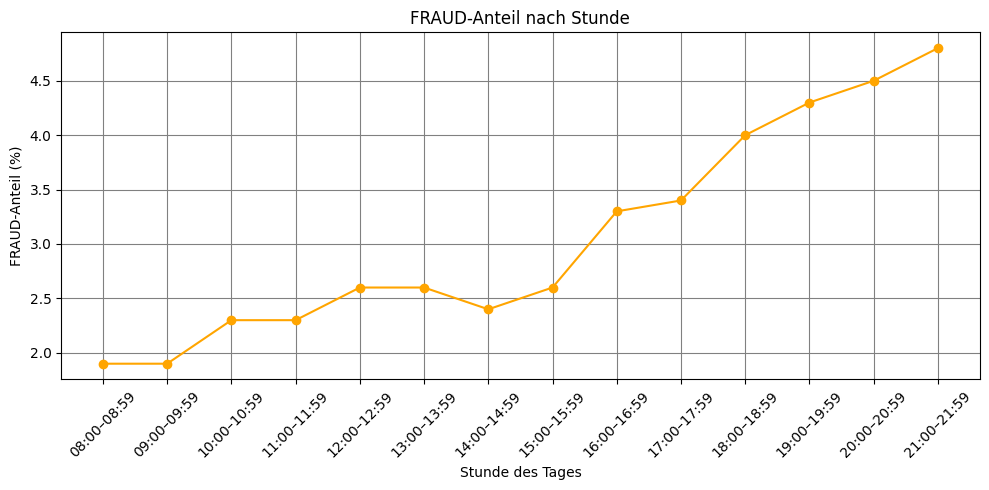

In [63]:
# Plot im White Style
fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Plot zeichnen
ax.plot(hourly_fraud_df.index, hourly_fraud_df['FRAUD_Rate (%)'], marker='o', color='orange')

# Achsentitel und Styling
ax.set_title('FRAUD-Anteil nach Stunde', color='black')
ax.set_xlabel('Stunde des Tages', color='black')
ax.set_ylabel('FRAUD-Anteil (%)', color='black')

# Ticks & Gitter
ax.tick_params(axis='x', colors='black', rotation=45)
ax.tick_params(axis='y', colors='black')
ax.grid(True, color='gray')

plt.tight_layout()
plt.show()

In [64]:
# Neue Feature-Spalte basierend auf Transaktionsstunde
df_model_labeled['is_risky_hour'] = df_model_labeled['hour'].apply(lambda h: 1 if 18 <= h <= 21 else 0)

# Kontrolle
print(df_model_labeled[['hour', 'is_risky_hour']].head(150))


     hour  is_risky_hour
0       8              0
1       8              0
2       8              0
3       9              0
4       9              0
..    ...            ...
145    20              1
146    20              1
147    20              1
148    11              0
149    12              0

[150 rows x 2 columns]


In [65]:
df_model_labeled['store_id'].nunique()

10

In [66]:
# 1. FRAUD-Transaktionen pro Store
fraud_per_store = df_model_labeled[df_model_labeled['label'] == 'FRAUD']['store_id'].value_counts()

In [67]:
# 2. Alle Transaktionen pro Store
total_per_store = df_model_labeled['store_id'].value_counts()

In [68]:
# 3. FRAUD-Rate pro Store (%)
fraud_rate_per_store = (fraud_per_store / total_per_store).round(3) * 100

In [69]:
# 4. Zusammenfassen in DataFrame
store_fraud_df = pd.DataFrame({
    'Total_Transactions': total_per_store,
    'FRAUD_Transactions': fraud_per_store.fillna(0).astype(int),
    'FRAUD_Rate (%)': fraud_rate_per_store.fillna(0)
}).sort_values(by='FRAUD_Rate (%)', ascending=False)

In [70]:
# Optional: nur die Top 10 riskantesten Stores anzeigen
print(store_fraud_df)


                                      Total_Transactions  FRAUD_Transactions  FRAUD_Rate (%)
store_id                                                                                    
664c9b33-0553-4050-9dff-5afc3aa3334b               14043                 467             3.3
7ddf76eb-ef7c-46e7-a337-9273ddba3dfd               18864                 595             3.2
9aaa4004-eacd-425d-89ac-5e3d64dc9426               12412                 393             3.2
027bcee3-7968-4127-a201-9c9c45a35157               12331                 381             3.1
29b64dcc-72e4-4dc9-b482-b169a7e9037f               11724                 366             3.1
3b647609-851c-4e92-a0a5-cb1d824347bb               17171                 533             3.1
75cf982f-abc4-4e88-8d67-70f6767fe5d0               10243                 317             3.1
88a1ecdf-2fe9-4517-88ea-170959aad9bb               18198                 566             3.1
8971e6e2-67c8-4ebd-9156-8f2fd2d4e6d5               18578              

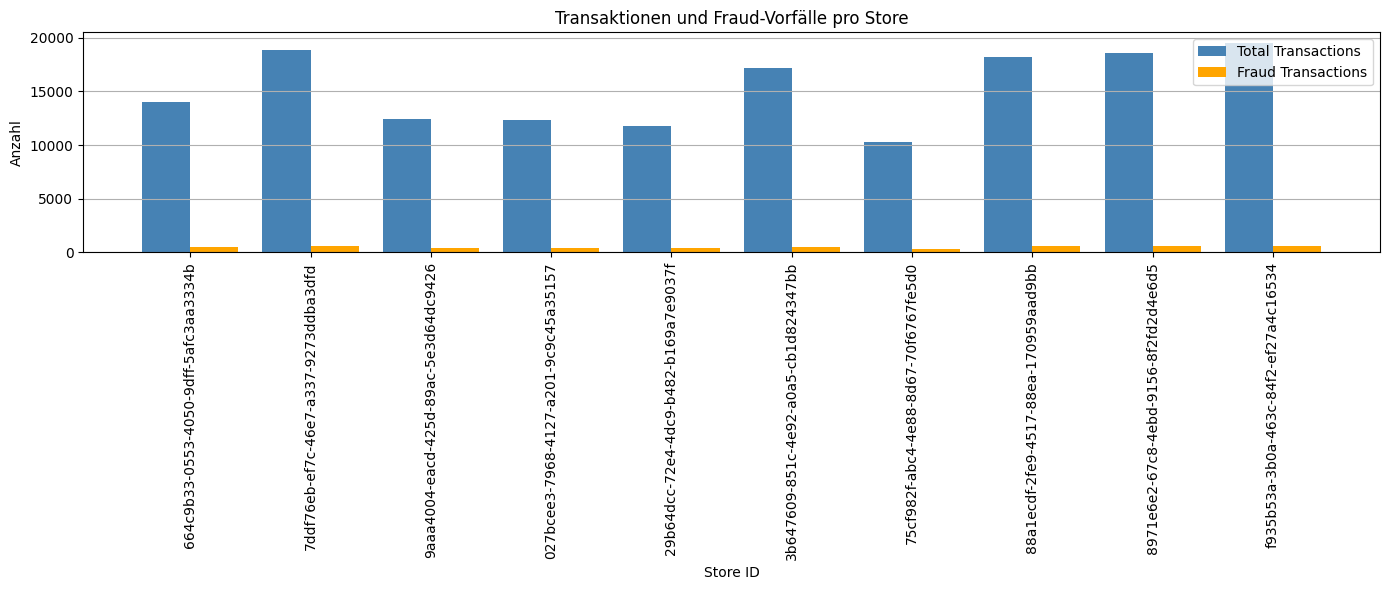

In [71]:
# Daten definieren
data = {
    'store_id': [
        '664c9b33-0553-4050-9dff-5afc3aa3334b',
        '7ddf76eb-ef7c-46e7-a337-9273ddba3dfd',
        '9aaa4004-eacd-425d-89ac-5e3d64dc9426',
        '027bcee3-7968-4127-a201-9c9c45a35157',
        '29b64dcc-72e4-4dc9-b482-b169a7e9037f',
        '3b647609-851c-4e92-a0a5-cb1d824347bb',
        '75cf982f-abc4-4e88-8d67-70f6767fe5d0',
        '88a1ecdf-2fe9-4517-88ea-170959aad9bb',
        '8971e6e2-67c8-4ebd-9156-8f2fd2d4e6d5',
        'f935b53a-3b0a-463c-84f2-ef27a4c16534'
    ],
    'Total_Transactions': [14043, 18864, 12412, 12331, 11724, 17171, 10243, 18198, 18578, 19520],
    'FRAUD_Transactions': [467, 595, 393, 381, 366, 533, 317, 566, 558, 590]
}

# DataFrame erstellen
df = pd.DataFrame(data)

# Positionen für die Balken
x = np.arange(len(df['store_id']))
width = 0.4

# Plot
plt.figure(figsize=(14, 6))
plt.bar(x - width/2, df['Total_Transactions'], width, label='Total Transactions', color='steelblue')
plt.bar(x + width/2, df['FRAUD_Transactions'], width, label='Fraud Transactions', color='orange')

# Achsen und Beschriftung
plt.xlabel('Store ID')
plt.ylabel('Anzahl')
plt.title('Transaktionen und Fraud-Vorfälle pro Store')
plt.xticks(x, df['store_id'], rotation=90)
plt.legend()
plt.tight_layout()
plt.grid(axis='y')

plt.show()

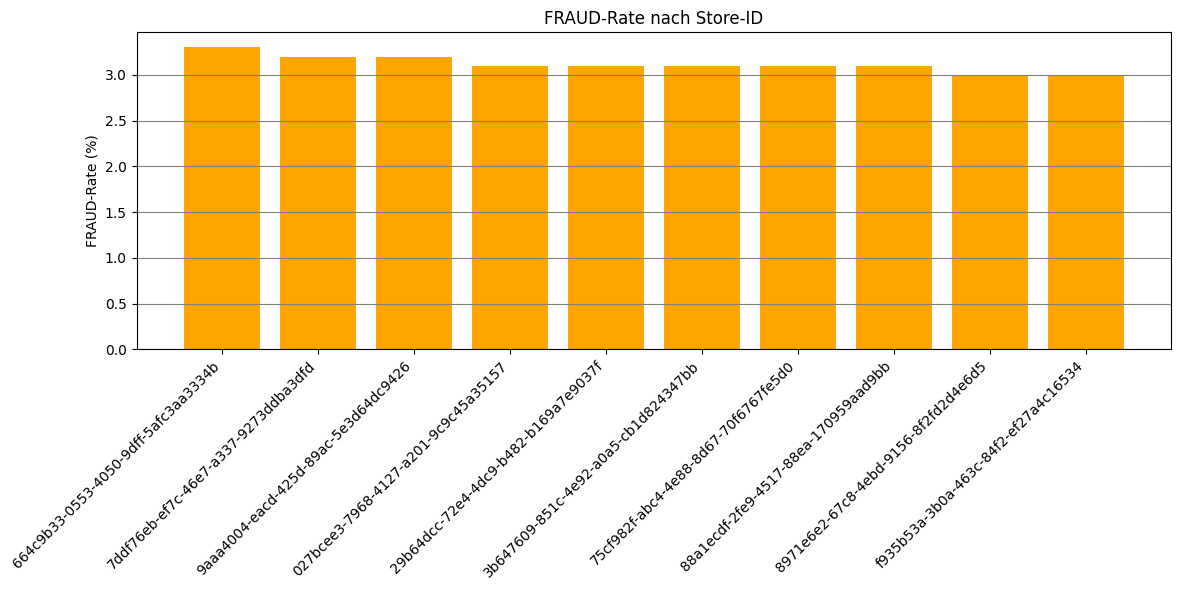

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

# Daten vorbereiten
data = {
    'store_id': [
        '664c9b33-0553-4050-9dff-5afc3aa3334b', '7ddf76eb-ef7c-46e7-a337-9273ddba3dfd',
        '9aaa4004-eacd-425d-89ac-5e3d64dc9426', '027bcee3-7968-4127-a201-9c9c45a35157',
        '29b64dcc-72e4-4dc9-b482-b169a7e9037f', '3b647609-851c-4e92-a0a5-cb1d824347bb',
        '75cf982f-abc4-4e88-8d67-70f6767fe5d0', '88a1ecdf-2fe9-4517-88ea-170959aad9bb',
        '8971e6e2-67c8-4ebd-9156-8f2fd2d4e6d5', 'f935b53a-3b0a-463c-84f2-ef27a4c16534'
    ],
    'FRAUD_Rate (%)': [3.3, 3.2, 3.2, 3.1, 3.1, 3.1, 3.1, 3.1, 3.0, 3.0]
}

df = pd.DataFrame(data)

# Plot mit weißem Hintergrund
fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Balkendiagramm
ax.bar(df['store_id'], df['FRAUD_Rate (%)'], color='orange')

# Achsentitel & Formatierung
ax.set_ylabel('FRAUD-Rate (%)', color='black')
ax.set_title('FRAUD-Rate nach Store-ID', color='black')
ax.set_xticks(range(len(df['store_id'])))
ax.set_xticklabels(df['store_id'], rotation=45, ha='right', color='black')
ax.tick_params(axis='y', colors='black')
ax.grid(axis='y', color='gray')

plt.tight_layout()
plt.show()


In [73]:
# 1. Wochentag extrahieren: 0 = Montag, 6 = Sonntag
df_model_labeled['weekday'] = df_model_labeled['transaction_start'].dt.weekday



In [74]:
# 2. Gesamtanzahl Transaktionen pro Tag
total_by_day = df_model_labeled['weekday'].value_counts().sort_index()



In [75]:
# 3. Anzahl FRAUD-Transaktionen pro Tag
fraud_by_day = df_model_labeled[df_model_labeled['label'] == 'FRAUD']['weekday'].value_counts().sort_index()



In [76]:
# 4. FRAUD-Rate pro Wochentag (%)
fraud_rate_by_day = (fraud_by_day / total_by_day).round(3) * 100


In [77]:

# 5. Zusammenfassen in Tabelle
weekday_fraud_df = pd.DataFrame({
    'Total_Transactions': total_by_day,
    'FRAUD_Transactions': fraud_by_day.fillna(0).astype(int),
    'FRAUD_Rate (%)': fraud_rate_by_day.fillna(0)
})



In [78]:
# 6. Wochentagsnamen ergänzen
weekday_names = ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag']
weekday_fraud_df.index = weekday_names


In [79]:

# 7. Ausgabe
print(weekday_fraud_df)

            Total_Transactions  FRAUD_Transactions  FRAUD_Rate (%)
Montag                   25728                 801             3.1
Dienstag                 15634                 479             3.1
Mittwoch                 14509                 421             2.9
Donnerstag               18204                 585             3.2
Freitag                  35145                1090             3.1
Samstag                  43864                1390             3.2


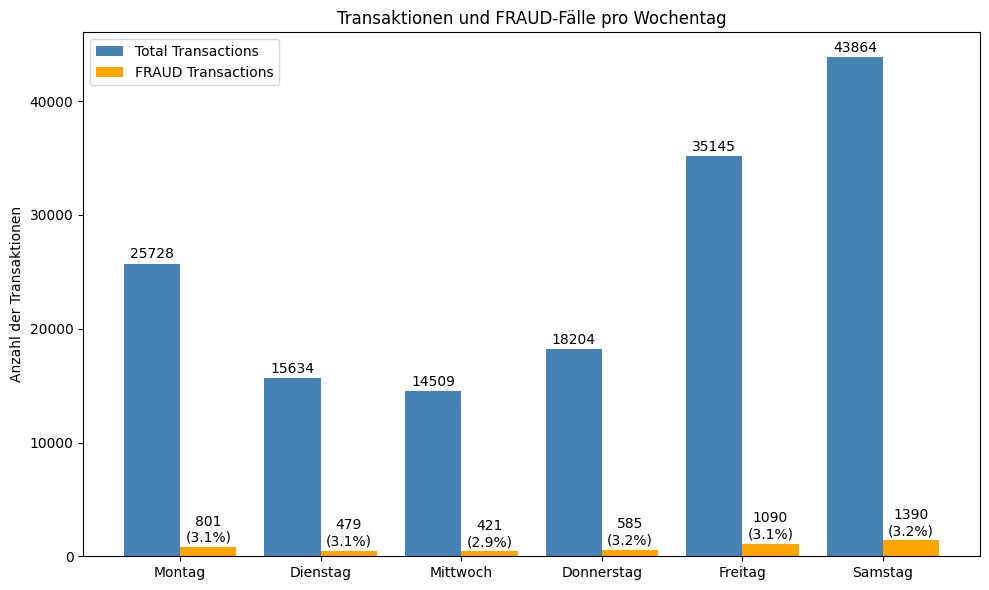

In [80]:
# Daten definieren
data = {
    'Wochentag': ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag'],
    'Total_Transactions': [25728, 15634, 14509, 18204, 35145, 43864],
    'FRAUD_Transactions': [801, 479, 421, 585, 1090, 1390],
    'FRAUD_Rate (%)': [3.1, 3.1, 2.9, 3.2, 3.1, 3.2]
}

# DataFrame erstellen
df = pd.DataFrame(data)

# Balkendiagramm: Total vs. Fraud pro Wochentag
x = range(len(df))
plt.figure(figsize=(10, 6))
bar1 = plt.bar([i - 0.2 for i in x], df['Total_Transactions'], width=0.4, label='Total Transactions', color='steelblue')
bar2 = plt.bar([i + 0.2 for i in x], df['FRAUD_Transactions'], width=0.4, label='FRAUD Transactions', color='orange')

# Achsen & Beschriftung
plt.xticks(x, df['Wochentag'])
plt.ylabel('Anzahl der Transaktionen')
plt.title('Transaktionen und FRAUD-Fälle pro Wochentag')
plt.legend()

# Werte einblenden
for i, bar in enumerate(bar1):
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, y + 200, str(int(y)), ha='center', va='bottom')

for i, bar in enumerate(bar2):
    y = bar.get_height()
    label = f"{int(y)}\n({df['FRAUD_Rate (%)'][i]}%)"
    plt.text(bar.get_x() + bar.get_width() / 2, y + 200, label, ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [81]:
# 1. Zeilen aus Artikeldaten (filtered_lines), die zur Kategorie 'SNACKS' gehören
snack_lines = filtered_lines[filtered_lines['category'] == 'SNACKS']

# 2. Anzahl SNACKS pro Transaktion zählen
snack_counts = snack_lines.groupby('transaction_id').size().reset_index(name='snack_count')

# 3. Merge auf df_model_labeled
df_model_labeled = df_model_labeled.merge(snack_counts, left_on='id', right_on='transaction_id', how='left')

# 4. Fehlende Werte (Transaktionen ohne Snacks) mit 0 füllen
df_model_labeled['snack_count'] = df_model_labeled['snack_count'].fillna(0).astype(int)

# 5. Spalte transaction_id entfernen (nicht mehr nötig)
df_model_labeled.drop(columns='transaction_id', inplace=True)

# 6. Kontrolle
print(df_model_labeled[['snack_count', 'label']].head())


   snack_count   label
0            0  NORMAL
1            0  NORMAL
2            0  NORMAL
3            0  NORMAL
4            0  NORMAL


In [82]:
# Durchschnittliche Anzahl Snacks je Label (FRAUD vs. NORMAL)
avg_snack_count = df_model_labeled.groupby('label')['snack_count'].mean().round(2)

print("\nDurchschnittlicher snack_count je Label:")
print(avg_snack_count)



Durchschnittlicher snack_count je Label:
label
FRAUD     0.08
NORMAL    0.02
Name: snack_count, dtype: float64


In [83]:
# Anzahl Artikel pro (transaction_id, category)
category_counts = filtered_lines.groupby(['transaction_id', 'category']).size().reset_index(name='category_count')


In [84]:
# Pro Transaktion: höchste Artikelanzahl innerhalb einer Kategorie
max_cat_count_per_tx = category_counts.groupby('transaction_id')['category_count'].max().reset_index(name='max_category_count')

# Merge auf df_model_labeled
df_model_labeled = df_model_labeled.merge(max_cat_count_per_tx, left_on='id', right_on='transaction_id', how='left')
df_model_labeled.drop(columns='transaction_id', inplace=True)

# Kontrolle
print(df_model_labeled[['max_category_count', 'label']].head())


   max_category_count   label
0                   6  NORMAL
1                   3  NORMAL
2                   2  NORMAL
3                   2  NORMAL
4                   4  NORMAL


In [85]:
# Durchschnittlicher max_category_count pro Label
avg_max_cat_count = df_model_labeled.groupby('label')['max_category_count'].mean().round(2)

print("\nDurchschnittlich häufigste Kategorieanzahl je Transaktion (max_category_count):")
print(avg_max_cat_count)

# Optional: Verteilung als Tabelle (binned counts)
binned = df_model_labeled.copy()
binned['max_cat_bucket'] = pd.cut(binned['max_category_count'], bins=[0,1,2,3,4,5,10,20,50], include_lowest=True)

# Verteilung je Bucket nach Label
bucket_table = binned.groupby(['label', 'max_cat_bucket']).size().unstack().fillna(0).astype(int)

print("\nVerteilung der max_category_count Buckets je Label:")
print(bucket_table)



Durchschnittlich häufigste Kategorieanzahl je Transaktion (max_category_count):
label
FRAUD     5.93
NORMAL    5.55
Name: max_category_count, dtype: float64

Verteilung der max_category_count Buckets je Label:
max_cat_bucket  (-0.001, 1.0]  (1.0, 2.0]  (2.0, 3.0]  (3.0, 4.0]  (4.0, 5.0]  (5.0, 10.0]  (10.0, 20.0]  (20.0, 50.0]
label                                                                                                                 
FRAUD                     928         691         536         406         335         1118           595           157
NORMAL                  28095       25451       18068       13807       10937        30910         17234          3794


C:\Users\felix\AppData\Local\Temp\ipykernel_12340\2751492732.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_table = binned.groupby(['label', 'max_cat_bucket']).size().unstack().fillna(0).astype(int)


In [86]:
# 1. Berechne die Anzahl Artikel pro Kategorie und Transaktion
dominant_category_counts = filtered_lines.groupby(['transaction_id', 'category']).size().reset_index(name='count')

# 2. Bestimme die dominante Kategorie je Transaktion
dominant_category = dominant_category_counts.sort_values(['transaction_id', 'count'], ascending=[True, False]) \
    .drop_duplicates('transaction_id')[['transaction_id', 'category']] \
    .rename(columns={'category': 'dominant_category'})

# 3. Merge: dominante Kategorie in df_model_labeled einfügen
df_model_labeled = df_model_labeled.merge(dominant_category, left_on='id', right_on='transaction_id', how='left')

# 4. Aufräumen: überflüssige Merge-Spalte entfernen
df_model_labeled.drop(columns='transaction_id', inplace=True)

# 5. Optional: has_dominant_category Flag wiederherstellen (wenn nicht mehr vorhanden)
if 'has_dominant_category' not in df_model_labeled.columns:
    df_model_labeled['has_dominant_category'] = (df_model_labeled['max_category_count'] > 10).astype(int)

# 6. Kontrolle: Anzeige der wichtigsten Spalten
print(df_model_labeled[['dominant_category', 'max_category_count', 'has_dominant_category']].head(10))



          dominant_category  max_category_count  has_dominant_category
0                 BEVERAGES                   6                      0
1  FRUITS_VEGETABLES_PIECES                   3                      0
2  FRUITS_VEGETABLES_PIECES                   2                      0
3  FRUITS_VEGETABLES_PIECES                   2                      0
4  FRUITS_VEGETABLES_PIECES                   4                      0
5  FRUITS_VEGETABLES_PIECES                   4                      0
6  FRUITS_VEGETABLES_PIECES                  19                      1
7  FRUITS_VEGETABLES_PIECES                   2                      0
8  FRUITS_VEGETABLES_PIECES                  11                      1
9              FROZEN_GOODS                   1                      0


In [87]:
df_model_labeled.head(5)

,id,store_id,cash_desk,transaction_start,transaction_end,total_amount,n_lines,payment_medium,damage,label,sales_price_sum,sales_price_mean,sales_price_max,camera_certainty_mean,camera_certainty_min,was_voided_sum,category_nunique,sold_by_weight_sum,age_restricted_sum,opening_date,location,state,urbanization,sco_introduction,has_snacks,has_beverages,has_frozen_goods,risky_category_score,transaction_duration_seconds,articles_per_minute,average_price_per_article,has_cash_payment,voided_articles_count,voided_articles_ratio,has_high_voided_ratio,low_camera_certainty_flag,hour,is_risky_hour,weekday,snack_count,max_category_count,dominant_category,has_dominant_category
0,1e5e4083-6f6a-4277-918d-ebb253ff8869,664c9b33-0553-4050-9dff-5afc3aa3334b,2,2022-02-14 08:10:42,2022-02-14 08:11:50.819448,96.57,14,CREDIT_CARD,0.0,NORMAL,96.57,6.897857,32.39,0.274696,0.185360,0,4,0,0,2006-06-19,Karlsruhe,Baden-Württemberg,TOWNS,2022-02-13,0,1,1,3,68.819448,12.21,6.90,0,0,0.0,0,1,8,0,0,0,6,BEVERAGES,0
1,4a8fcf02-5d68-4138-8029-a493643e755d,664c9b33-0553-4050-9dff-5afc3aa3334b,3,2022-02-14 08:20:09,2022-02-14 08:20:52.679465,57.66,6,CREDIT_CARD,0.0,NORMAL,57.66,9.610000,34.11,0.281571,0.267869,0,3,0,0,2006-06-19,Karlsruhe,Baden-Württemberg,TOWNS,2022-02-13,0,1,1,3,43.679465,8.24,9.61,0,0,0.0,0,0,8,0,0,0,3,FRUITS_VEGETABLES_PIECES,0
2,aa340ad4-b279-4835-b347-11f749726ec1,664c9b33-0553-4050-9dff-5afc3aa3334b,1,2022-02-14 08:42:12,2022-02-14 08:42:42.023526,12.20,3,CREDIT_CARD,0.0,NORMAL,12.20,4.066667,8.19,0.288782,0.281739,0,2,0,0,2006-06-19,Karlsruhe,Baden-Württemberg,TOWNS,2022-02-13,0,1,0,2,30.023526,6.00,4.07,0,0,0.0,0,0,8,0,0,0,2,FRUITS_VEGETABLES_PIECES,0
3,0b635b69-1578-44b4-a4f5-77b5bf6a337d,664c9b33-0553-4050-9dff-5afc3aa3334b,2,2022-02-14 09:02:09,2022-02-14 09:02:36.613637,41.34,3,CREDIT_CARD,0.0,NORMAL,41.34,13.780000,25.02,0.296226,0.267349,0,2,0,0,2006-06-19,Karlsruhe,Baden-Württemberg,TOWNS,2022-02-13,0,1,0,2,27.613637,6.52,13.78,0,0,0.0,0,0,9,0,0,0,2,FRUITS_VEGETABLES_PIECES,0
4,e3415138-ca98-4a21-a9ad-33e46f4f1c70,664c9b33-0553-4050-9dff-5afc3aa3334b,3,2022-02-14 09:09:30,2022-02-14 09:10:20.716049,57.41,6,CREDIT_CARD,0.0,NORMAL,57.41,9.568333,23.22,0.266609,0.228188,0,2,0,0,2006-06-19,Karlsruhe,Baden-Württemberg,TOWNS,2022-02-13,0,0,1,1,50.716049,7.10,9.57,0,0,0.0,0,1,9,0,0,0,4,FRUITS_VEGETABLES_PIECES,0


In [88]:

# 5. Kontrolle: Dominante Kategorie + Artikelanzahl + Flag anzeigen
print(df_model_labeled[['dominant_category', 'max_category_count', 'has_dominant_category']].head(100))

           dominant_category  max_category_count  has_dominant_category
0                  BEVERAGES                   6                      0
1   FRUITS_VEGETABLES_PIECES                   3                      0
2   FRUITS_VEGETABLES_PIECES                   2                      0
3   FRUITS_VEGETABLES_PIECES                   2                      0
4   FRUITS_VEGETABLES_PIECES                   4                      0
..                       ...                 ...                    ...
95  FRUITS_VEGETABLES_PIECES                  14                      1
96                 BEVERAGES                   3                      0
97                 BEVERAGES                   3                      0
98  FRUITS_VEGETABLES_PIECES                   6                      0
99                 BEVERAGES                   1                      0

[100 rows x 3 columns]


In [89]:
# One-Hot-Encoding für die dominante Kategorie
# df_model_labeled = pd.get_dummies(df_model_labeled, columns=['dominant_category'], prefix='dom_cat')

# Kontrolle: Ausgabe der neuen Spaltennamen (Ausschnitt)
print([col for col in df_model_labeled.columns if col.startswith('dom_cat_')][:10])


[]


In [90]:
# Verteilung der dominanten Kategorien bei FRAUD
dominant_fraud_counts = df_model_labeled[df_model_labeled['label'] == 'FRAUD']['dominant_category'].value_counts()

# Ausgabe anzeigen
print("\nTop-dominante Kategorien bei FRAUD:")
print(dominant_fraud_counts.head(10))






Top-dominante Kategorien bei FRAUD:
dominant_category
FRUITS_VEGETABLES_PIECES    2597
BEVERAGES                    902
LONG_SHELF_LIFE              387
DAIRY                        328
SNACKS                       276
FROZEN_GOODS                 139
CONVENIENCE                   80
PERSONAL_CARE                 22
FRUITS_VEGETABLES             19
HOUSEHOLD                     11
Name: count, dtype: int64


In [91]:
# Verteilung bei NORMAL
dominant_normal_counts = df_model_labeled[df_model_labeled['label'] == 'NORMAL']['dominant_category'].value_counts()


In [92]:
# Ausgabe vergleichen
print("\nTop-dominante Kategorien bei FRAUD:")
print(dominant_fraud_counts.head(10))

print("\nTop-dominante Kategorien bei NORMAL:")
print(dominant_normal_counts.head(10))


Top-dominante Kategorien bei FRAUD:
dominant_category
FRUITS_VEGETABLES_PIECES    2597
BEVERAGES                    902
LONG_SHELF_LIFE              387
DAIRY                        328
SNACKS                       276
FROZEN_GOODS                 139
CONVENIENCE                   80
PERSONAL_CARE                 22
FRUITS_VEGETABLES             19
HOUSEHOLD                     11
Name: count, dtype: int64

Top-dominante Kategorien bei NORMAL:
dominant_category
FRUITS_VEGETABLES_PIECES    81614
BEVERAGES                   32069
LONG_SHELF_LIFE             13328
DAIRY                       10260
FROZEN_GOODS                 5624
CONVENIENCE                  2423
PERSONAL_CARE                1009
ALCOHOL                       762
HOUSEHOLD                     632
FRUITS_VEGETABLES             466
Name: count, dtype: int64


In [93]:
# Spalte definieren (anpassen, falls nötig)
dominant_col = 'dominant_category'  # oder 'dominant_category_x' – je nachdem, was bei dir passt

# 1. Absolute Verteilungen
fraud_counts = df_model_labeled[df_model_labeled['label'] == 'FRAUD'][dominant_col].value_counts()
normal_counts = df_model_labeled[df_model_labeled['label'] == 'NORMAL'][dominant_col].value_counts()

# 2. Prozentuale Verteilungen
fraud_pct = (fraud_counts / fraud_counts.sum() * 100).round(2)
normal_pct = (normal_counts / normal_counts.sum() * 100).round(2)

# 3. Zusammenfassen
comparison_df = pd.DataFrame({
    'FRAUD_Count': fraud_counts,
    'FRAUD_%': fraud_pct,
    'NORMAL_Count': normal_counts,
    'NORMAL_%': normal_pct
}).fillna(0).astype({'FRAUD_Count': 'int', 'NORMAL_Count': 'int'})

# 4. Sortiert nach höchstem Fraud-Anteil
comparison_df = comparison_df.sort_values(by='FRAUD_%', ascending=False)

# 5. Ausgabe
print(comparison_df.head(10))


                          FRAUD_Count  FRAUD_%  NORMAL_Count  NORMAL_%
dominant_category                                                     
FRUITS_VEGETABLES_PIECES         2597    54.49         81614     55.03
BEVERAGES                         902    18.93         32069     21.62
LONG_SHELF_LIFE                   387     8.12         13328      8.99
DAIRY                             328     6.88         10260      6.92
SNACKS                            276     5.79            18      0.01
FROZEN_GOODS                      139     2.92          5624      3.79
CONVENIENCE                        80     1.68          2423      1.63
PERSONAL_CARE                      22     0.46          1009      0.68
FRUITS_VEGETABLES                  19     0.40           466      0.31
HOUSEHOLD                          11     0.23           632      0.43


In [94]:
# Flag setzen: 1 = dominante Kategorie ist SNACKS, sonst 0
df_model_labeled['dominant_is_snacks'] = (df_model_labeled['dominant_category'] == 'SNACKS').astype(int)

# Kontrolle: Ausgabe der ersten 10 Werte
print(df_model_labeled[['dominant_category', 'dominant_is_snacks']].head(10))


          dominant_category  dominant_is_snacks
0                 BEVERAGES                   0
1  FRUITS_VEGETABLES_PIECES                   0
2  FRUITS_VEGETABLES_PIECES                   0
3  FRUITS_VEGETABLES_PIECES                   0
4  FRUITS_VEGETABLES_PIECES                   0
5  FRUITS_VEGETABLES_PIECES                   0
6  FRUITS_VEGETABLES_PIECES                   0
7  FRUITS_VEGETABLES_PIECES                   0
8  FRUITS_VEGETABLES_PIECES                   0
9              FROZEN_GOODS                   0


In [95]:
# Sicherstellen, dass 'hour' existiert
df_model_labeled['transaction_start'] = pd.to_datetime(df_model_labeled['transaction_start'])
df_model_labeled['hour'] = df_model_labeled['transaction_start'].dt.hour

# Nur Stunden von 8 bis 21 Uhr berücksichtigen
filtered_df = df_model_labeled[df_model_labeled['hour'].between(8, 21)]

# Gruppieren nach Stunde und dominierender Kategorie
category_counts = filtered_df.groupby(['hour', 'dominant_category']).size().reset_index(name='count')

# Für jede Stunde die häufigste Kategorie auswählen
top_category_per_hour = category_counts.sort_values(['hour', 'count'], ascending=[True, False]) \
                                       .drop_duplicates(subset='hour', keep='first') \
                                       .sort_values('hour')

# Ausgabe
print(top_category_per_hour)

     hour         dominant_category  count
6       8  FRUITS_VEGETABLES_PIECES   5485
18      9  FRUITS_VEGETABLES_PIECES   4383
31     10  FRUITS_VEGETABLES_PIECES   5645
43     11  FRUITS_VEGETABLES_PIECES   6715
56     12  FRUITS_VEGETABLES_PIECES   5782
69     13  FRUITS_VEGETABLES_PIECES   5348
82     14  FRUITS_VEGETABLES_PIECES   5878
95     15  FRUITS_VEGETABLES_PIECES   6813
108    16  FRUITS_VEGETABLES_PIECES   7318
121    17  FRUITS_VEGETABLES_PIECES   7266
134    18  FRUITS_VEGETABLES_PIECES   6963
147    19  FRUITS_VEGETABLES_PIECES   6561
159    20  FRUITS_VEGETABLES_PIECES   5370
172    21  FRUITS_VEGETABLES_PIECES   4684


In [96]:
# 2. Filter: Nur Stunden zwischen 08:00 und 21:00
filtered_df = df_model_labeled[df_model_labeled['hour'].between(8, 21)]


In [97]:
# 3. Gruppieren: Anzahl Transaktionen pro Stunde und Kategorie
category_hour_counts = filtered_df.groupby(['hour', 'dominant_category']).size().reset_index(name='count')


In [98]:
# 4. Ausgabe
print(category_hour_counts)

     hour dominant_category  count
0       8           ALCOHOL      1
1       8            BAKERY      3
2       8         BEVERAGES   2189
3       8       CONVENIENCE      3
4       8             DAIRY      6
..    ...               ...    ...
173    21         HOUSEHOLD     49
174    21   LONG_SHELF_LIFE   1048
175    21     PERSONAL_CARE     60
176    21            SNACKS     25
177    21           TOBACCO      3

[178 rows x 3 columns]


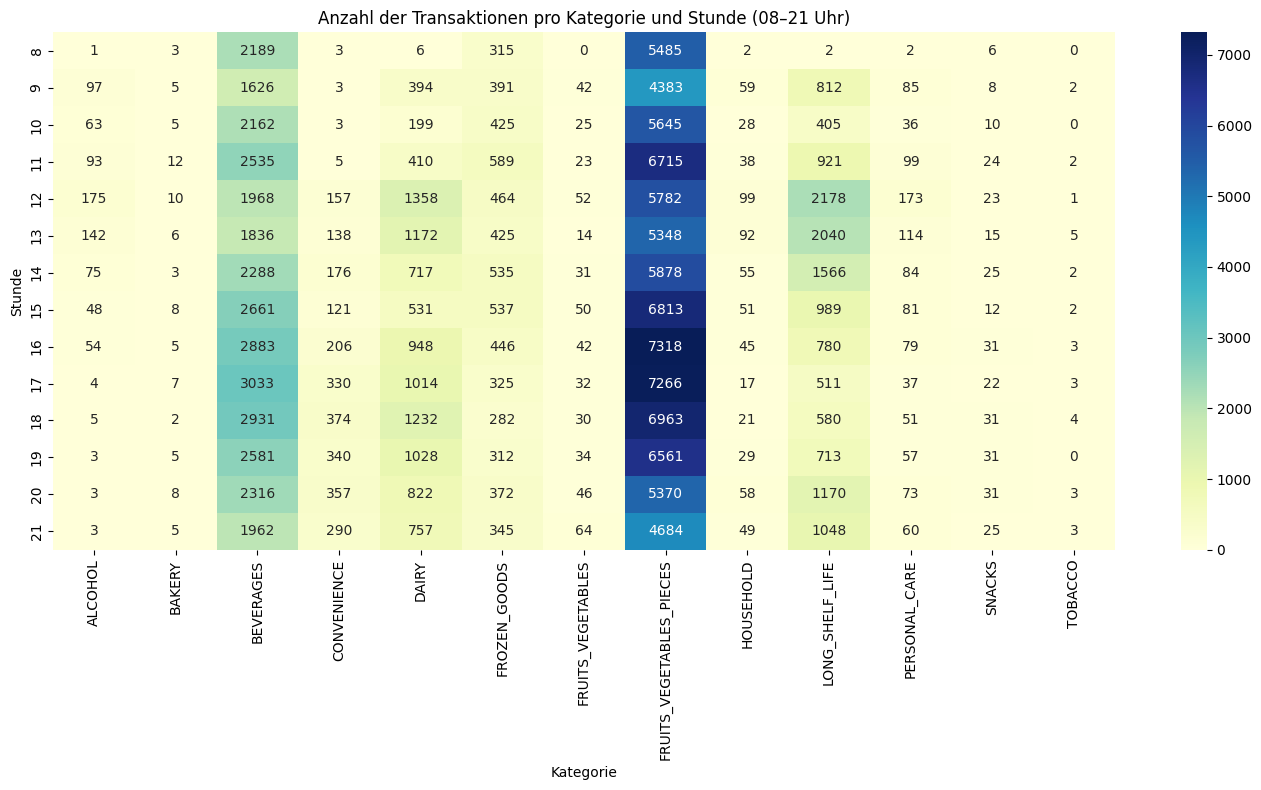

In [99]:
# Pivot-Tabelle: Stunden als Zeilen, Kategorien als Spalten
pivot_table = category_hour_counts.pivot_table(
    index='hour',
    columns='dominant_category',
    values='count',
    aggfunc='sum'
).fillna(0)

# Zeichnen der Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, annot=True, fmt='g', cmap='YlGnBu')
plt.title('Anzahl der Transaktionen pro Kategorie und Stunde (08–21 Uhr)')
plt.xlabel('Kategorie')
plt.ylabel('Stunde')
plt.tight_layout()
plt.show()

In [100]:
# Optional: Neue Spalte für "Risikolevel"
df_model_labeled['risky_score_bucket'] = pd.cut(
    df_model_labeled['risky_category_score'],
    bins=[-1, 0, 1, 2, 3, 10],
    labels=['0', '1', '2', '3', '4+']
)



In [101]:
# Durchschnittliche Transaktionsdauer je Risikolevel und Label
duration_by_risk = df_model_labeled.groupby(['label', 'risky_score_bucket'])['transaction_duration_seconds'].mean().round(1)



C:\Users\felix\AppData\Local\Temp\ipykernel_12340\894759064.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duration_by_risk = df_model_labeled.groupby(['label', 'risky_score_bucket'])['transaction_duration_seconds'].mean().round(1)


In [102]:
# Ausgabe als Tabelle
duration_by_risk = duration_by_risk.unstack().fillna(0)

print("\nDurchschnittliche Transaktionsdauer (Sekunden) je Risk-Score-Bucket:")
print(duration_by_risk)


Durchschnittliche Transaktionsdauer (Sekunden) je Risk-Score-Bucket:
risky_score_bucket     0     1     2      3     4+
label                                             
FRAUD               32.3  41.6  93.9  100.2  181.8
NORMAL              29.2  39.2  81.8  110.1  157.4


Zeigt an, das ab einem Risikolevel von 4 die FRAUD länger dauern. Es kommt in 4 wenn 4 oder mehr risky ccategories im einkauf dabei waren

In [103]:
df_model_labeled['is_suspiciously_risky_and_slow'] = (
    (df_model_labeled['risky_category_score'] >= 4) &
    (df_model_labeled['transaction_duration_seconds'] > 150)
).astype(int)


In [104]:
# Zeige nur Transaktionen mit hohem Risiko UND langer Dauer
suspicious_cases = df_model_labeled[df_model_labeled['is_suspiciously_risky_and_slow'] == 1]



In [105]:
# Zähle, wie viele davon FRAUD vs. NORMAL sind
label_counts = suspicious_cases['label'].value_counts()

print("\nAnzahl verdächtiger Transaktionen nach Label:")
print(label_counts)


Anzahl verdächtiger Transaktionen nach Label:
label
NORMAL    1170
FRAUD       53
Name: count, dtype: int64


In [106]:

# Optional: Prozentwerte anzeigen
label_percent = suspicious_cases['label'].value_counts(normalize=True).round(3) * 100
print("\nProzentuale Verteilung:")
print(label_percent)


Prozentuale Verteilung:
label
NORMAL    95.7
FRAUD      4.3
Name: proportion, dtype: float64


In [107]:
# Artikeldaten mit Transaktionslabel verbinden
lines_with_label = filtered_lines.merge(
    df_model_labeled[['id', 'label']],
    left_on='transaction_id',
    right_on='id',
    how='left'
)


In [108]:
# Durchschnitt je Label
similarity_avg = lines_with_label.groupby('label')['camera_product_similar'].mean().round(3)

print("Durchschnittliche Kamera-Ähnlichkeit je Label:")
print(similarity_avg)


Durchschnittliche Kamera-Ähnlichkeit je Label:
label
FRAUD     0.931615
NORMAL    0.943914
Name: camera_product_similar, dtype: object


In [109]:
print(df_model_labeled)

                                          id                              store_id  cash_desk   transaction_start            transaction_end  total_amount  n_lines payment_medium  damage   label  sales_price_sum  sales_price_mean  sales_price_max  camera_certainty_mean  camera_certainty_min  was_voided_sum  category_nunique  sold_by_weight_sum  age_restricted_sum opening_date   location              state urbanization sco_introduction  has_snacks  has_beverages  has_frozen_goods  risky_category_score  transaction_duration_seconds  articles_per_minute  average_price_per_article  has_cash_payment  voided_articles_count  voided_articles_ratio  has_high_voided_ratio  low_camera_certainty_flag  hour  is_risky_hour  weekday  snack_count  max_category_count         dominant_category  has_dominant_category  dominant_is_snacks risky_score_bucket  is_suspiciously_risky_and_slow
0       1e5e4083-6f6a-4277-918d-ebb253ff8869  664c9b33-0553-4050-9dff-5afc3aa3334b          2 2022-02-14 08:10:42 2022-

In [110]:
df_model_labeled[df_model_labeled['label'] == 'FRAUD']

,id,store_id,cash_desk,transaction_start,transaction_end,total_amount,n_lines,payment_medium,damage,label,sales_price_sum,sales_price_mean,sales_price_max,camera_certainty_mean,camera_certainty_min,was_voided_sum,category_nunique,sold_by_weight_sum,age_restricted_sum,opening_date,location,state,urbanization,sco_introduction,has_snacks,has_beverages,has_frozen_goods,risky_category_score,transaction_duration_seconds,articles_per_minute,average_price_per_article,has_cash_payment,voided_articles_count,voided_articles_ratio,has_high_voided_ratio,low_camera_certainty_flag,hour,is_risky_hour,weekday,snack_count,max_category_count,dominant_category,has_dominant_category,dominant_is_snacks,risky_score_bucket,is_suspiciously_risky_and_slow
146,0679c72e-bb52-47fe-b4ac-f00e239b6761,664c9b33-0553-4050-9dff-5afc3aa3334b,3,2022-02-21 20:40:45,2022-02-21 20:41:21.665778,79.07,8,CREDIT_CARD,23.57,FRAUD,79.07,9.883750,35.26,0.336263,0.261288,0,4,0,0,2006-06-19,Karlsruhe,Baden-Württemberg,TOWNS,2022-02-13,0,0,1,1,36.665778,13.09,9.88,0,0,0.000,0,0,20,1,0,0,5,LONG_SHELF_LIFE,0,0,1,0
157,36a7d8b3-997b-42d2-8379-2a8b307a7c89,664c9b33-0553-4050-9dff-5afc3aa3334b,1,2022-02-22 19:30:24,2022-02-22 19:34:02.277559,342.22,33,CREDIT_CARD,3.41,FRAUD,342.22,10.370303,49.02,0.572095,0.257678,0,5,0,0,2006-06-19,Karlsruhe,Baden-Württemberg,TOWNS,2022-02-13,0,1,0,2,218.277559,9.07,10.37,0,0,0.000,0,0,19,1,1,0,17,FRUITS_VEGETABLES_PIECES,1,0,2,0
161,38ab96bc-96ee-4f6a-8d22-e67d7087d83e,664c9b33-0553-4050-9dff-5afc3aa3334b,3,2022-02-23 13:35:09,2022-02-23 13:35:24.436981,2.61,1,CREDIT_CARD,2.78,FRAUD,2.61,2.610000,2.61,0.996570,0.996570,0,1,0,0,2006-06-19,Karlsruhe,Baden-Württemberg,TOWNS,2022-02-13,0,0,0,0,15.436981,3.89,2.61,0,0,0.000,0,0,13,0,2,0,1,FRUITS_VEGETABLES_PIECES,0,0,0,0
247,97683ec6-a2a2-4312-a1a0-d466f739e82b,664c9b33-0553-4050-9dff-5afc3aa3334b,3,2022-02-28 08:25:24,2022-02-28 08:26:29.887728,38.09,7,CREDIT_CARD,8.36,FRAUD,38.09,5.441429,19.50,0.787376,0.414728,0,3,0,0,2006-06-19,Karlsruhe,Baden-Württemberg,TOWNS,2022-02-13,0,1,1,3,65.887728,6.37,5.44,0,0,0.000,0,0,8,0,0,0,5,FRUITS_VEGETABLES_PIECES,0,0,3,0
316,a07cc76e-058c-4ddd-9d18-19df5eb08a49,664c9b33-0553-4050-9dff-5afc3aa3334b,3,2022-03-04 10:22:39,2022-03-04 10:22:52.715194,1.39,1,CREDIT_CARD,0.59,FRAUD,1.39,1.390000,1.39,0.844613,0.844613,0,1,0,0,2006-06-19,Karlsruhe,Baden-Württemberg,TOWNS,2022-02-13,0,1,0,2,13.715194,4.37,1.39,0,0,0.000,0,0,10,0,4,0,1,BEVERAGES,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152916,529f0e14-e89c-471a-8ba7-fbe4df0d5c45,9aaa4004-eacd-425d-89ac-5e3d64dc9426,0,2023-12-22 21:15:03,2023-12-22 21:15:18.683084,7.84,1,CASH,23.70,FRAUD,7.84,7.840000,7.84,0.902616,0.902616,0,1,0,0,2002-02-01,Osnabrück,Niedersachsen,CITIES,2022-02-05,1,0,0,3,15.683084,3.83,7.84,1,0,0.000,0,0,21,1,4,1,1,SNACKS,0,1,3,0
153021,d661e3fc-b0f5-4df3-90f2-6783ea4dfab9,9aaa4004-eacd-425d-89ac-5e3d64dc9426,2,2023-12-29 13:38:18,2023-12-29 13:39:46.769135,57.18,12,CASH,7.20,FRAUD,57.18,4.765000,24.75,0.980062,0.929871,0,2,0,0,2002-02-01,Osnabrück,Niedersachsen,CITIES,2022-02-05,0,1,0,2,88.769135,8.11,4.76,1,0,0.000,0,0,13,0,4,0,7,FRUITS_VEGETABLES_PIECES,0,0,2,0
153058,769145d6-01e7-4d32-ba13-7bd7b4989191,9aaa4004-eacd-425d-89ac-5e3d64dc9426,1,2023-12-30 13:07:30,2023-12-30 13:08:09.608200,57.01,6,CREDIT_CARD,21.51,FRAUD,57.01,8.144286,22.77,0.989741,0.928187,1,3,0,0,2002-02-01,Osnabrück,Niedersachsen,CITIES,2022-02-05,0,1,1,3,39.608200,9.09,9.50,0,1,0.167,1,0,13,0,5,0,5,BEVERAGES,0,0,3,0
153076,2c8ffd33-d487-49b2-9961-2702667dceba,9aaa4004-eacd-425d-89ac-5e3d64dc9426,1,2023-12-30 19:26:33,2023-12-30 19:26:59.370579,69.72,6,CREDIT_CARD,13.60,FRAUD,88.51,12.644286,20.97,0.935518,0.751386,1,2,0,0,2002-02-01,Osnabrück,Niedersachsen,CITIES,2022-02-05,0,0,1,1,26.370579,13.65,11.62,0,1,0.167,1,0,19,1,5,0,4,FROZEN_GOODS,0,0,1,0


In [111]:
# Zielspalte in numerisch übersetzen: 0 = NORMAL, 1 = FRAUD
df_model_labeled['label_binary'] = df_model_labeled['label'].map({'NORMAL': 0, 'FRAUD': 1}).astype(int)


In [112]:
# Nur numerische Spalten für die Korrelation
numeric_df = df_model_labeled.select_dtypes(include=['number'])


In [113]:
# Korrelation berechnen
corr_matrix = numeric_df.corr()


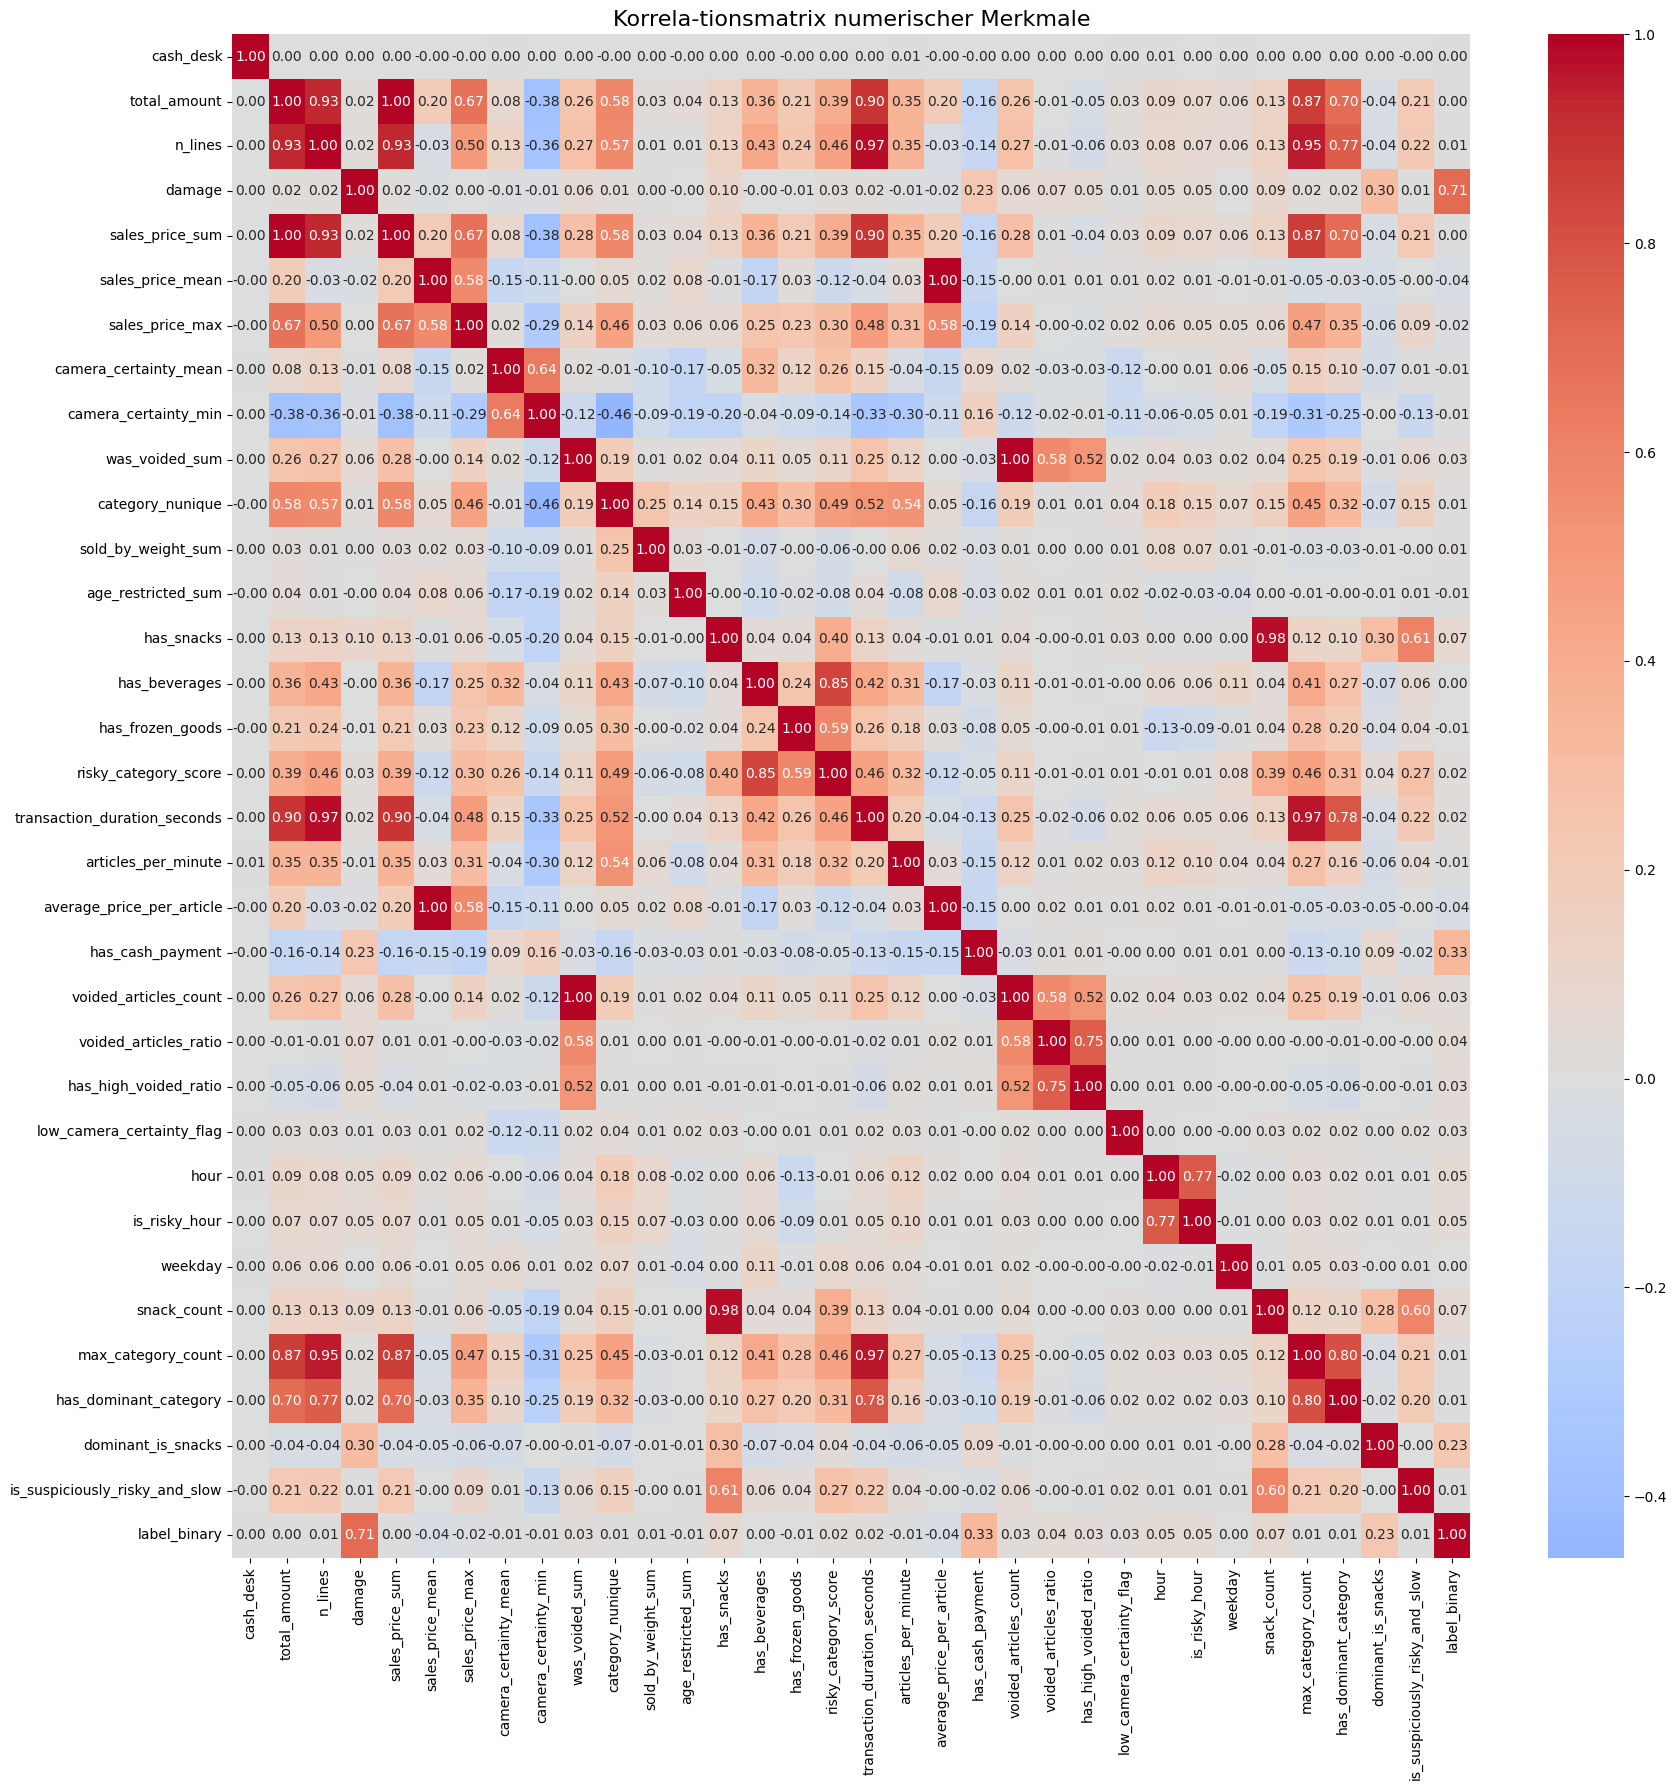

In [114]:
# Plot
plt.figure(figsize=(18, 18))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Korrela­tionsmatrix numerischer Merkmale", fontsize=16)
plt.tight_layout()
plt.show()


In [115]:
# Alle Stores aus stores.csv
print("Stores in stores.csv:", df_stores['id'].nunique())

# Alle Stores in ALLEN Transaktionen (nicht nur gelabelt!)
print("Stores in allen Transaktionen:", df_trans['id'].nunique())

# Stores in df_model_labeled (nur FRAUD/NORMAL)
print("Stores in df_model_labeled:", df_model_labeled['id'].nunique())

# Welche fehlen?
missing_stores = set(df_stores['id']) - set(df_model_labeled['id'])
print("Fehlende Store-IDs:", missing_stores)


Stores in stores.csv: 18
Stores in allen Transaktionen: 1534158
Stores in df_model_labeled: 153084
Fehlende Store-IDs: {'6a7406ec-4ebb-4df7-83ce-9528663e553e', '3b647609-851c-4e92-a0a5-cb1d824347bb', '29b64dcc-72e4-4dc9-b482-b169a7e9037f', '581831fc-6a03-4e38-9025-0a889b7fe542', '3fffea06-686f-42bd-8362-818af86b48a9', 'f935b53a-3b0a-463c-84f2-ef27a4c16534', '88a1ecdf-2fe9-4517-88ea-170959aad9bb', '46e6da32-f4b0-40f3-ada7-fc6ca81ed85d', 'd3892a9e-8cbc-4237-be9c-211435dc92c0', '75cf982f-abc4-4e88-8d67-70f6767fe5d0', '027bcee3-7968-4127-a201-9c9c45a35157', '7ddf76eb-ef7c-46e7-a337-9273ddba3dfd', '664c9b33-0553-4050-9dff-5afc3aa3334b', 'b0973ffa-ce15-41e0-9de7-1390598e24f2', 'ed996b17-17d6-47e8-9262-d1d02b52cdb4', 'cd833b6b-0666-42df-b538-6bb1f189b66e', '8971e6e2-67c8-4ebd-9156-8f2fd2d4e6d5', '9aaa4004-eacd-425d-89ac-5e3d64dc9426'}


In [116]:
# 1. Anzahl Stores laut Stammdaten
total_stores = df_stores['id'].nunique()
print("📦 Anzahl Stores in stores.csv:", total_stores)



📦 Anzahl Stores in stores.csv: 18


In [117]:
# 2. Anzahl Stores in ALLEN Transaktionen (also transactions_train, mit allen Labels!)
stores_in_all_transactions = df_trans['store_id'].nunique()
print("🧾 Stores in ALLEN Transaktionen:", stores_in_all_transactions)


🧾 Stores in ALLEN Transaktionen: 10


In [118]:
# 3. Anzahl Stores in gelabelten Daten (FRAUD + NORMAL)
stores_in_labeled_data = df_model_labeled['store_id'].nunique()
print("🏷️ Stores in df_model_labeled:", stores_in_labeled_data)


🏷️ Stores in df_model_labeled: 10


In [119]:
# 4. Welche Store-IDs fehlen in den gelabelten Daten?
missing_from_labeled = set(df_stores['id']) - set(df_model_labeled['store_id'])
print("\n❌ Fehlen in df_model_labeled:", len(missing_from_labeled))
print("IDs:", missing_from_labeled)



❌ Fehlen in df_model_labeled: 8
IDs: {'6a7406ec-4ebb-4df7-83ce-9528663e553e', '581831fc-6a03-4e38-9025-0a889b7fe542', '3fffea06-686f-42bd-8362-818af86b48a9', '46e6da32-f4b0-40f3-ada7-fc6ca81ed85d', 'd3892a9e-8cbc-4237-be9c-211435dc92c0', 'b0973ffa-ce15-41e0-9de7-1390598e24f2', 'ed996b17-17d6-47e8-9262-d1d02b52cdb4', 'cd833b6b-0666-42df-b538-6bb1f189b66e'}


In [120]:

# 5. Welche Store-IDs fehlen sogar in allen Transaktionen?
missing_from_all_transactions = set(df_stores['id']) - set(df_trans['store_id'])
print("\n🚫 Fehlen auch in df_trans:", len(missing_from_all_transactions))
print("IDs:", missing_from_all_transactions)


🚫 Fehlen auch in df_trans: 8
IDs: {'6a7406ec-4ebb-4df7-83ce-9528663e553e', '581831fc-6a03-4e38-9025-0a889b7fe542', '3fffea06-686f-42bd-8362-818af86b48a9', '46e6da32-f4b0-40f3-ada7-fc6ca81ed85d', 'd3892a9e-8cbc-4237-be9c-211435dc92c0', 'b0973ffa-ce15-41e0-9de7-1390598e24f2', 'ed996b17-17d6-47e8-9262-d1d02b52cdb4', 'cd833b6b-0666-42df-b538-6bb1f189b66e'}


In [121]:
# Stelle sicher, dass transaction_start ein datetime ist
df_model_labeled['transaction_start'] = pd.to_datetime(df_model_labeled['transaction_start'])

# Filter auf Transaktionen im Jahr 2023
damage_2023 = df_model_labeled[df_model_labeled['transaction_start'].dt.year == 2023]['damage']
damage_2022 = df_model_labeled[df_model_labeled['transaction_start'].dt.year == 2022]['damage']

In [122]:
# Durchschnitt berechnen
avg_damage_2023 = damage_2023.mean()
avg_damage_2022 = damage_2022.mean()
print("Durchschnittlicher Schaden 2023:", avg_damage_2023)
print("Durchschnittlicher Schaden 2022:", avg_damage_2022)

Durchschnittlicher Schaden 2023: 0.25400688877448463
Durchschnittlicher Schaden 2022: 0.2428725070627395


In [123]:
# Stelle sicher, dass 'transaction_start' als datetime erkannt wird
df_model_labeled['transaction_start'] = pd.to_datetime(df_model_labeled['transaction_start'])

# Filtere nur relevante Jahre
df_filtered = df_model_labeled[df_model_labeled['transaction_start'].dt.year.isin([2022, 2023])]

# Erzeuge eine neue Spalte für Jahr und Monat
df_filtered['year_month'] = df_filtered['transaction_start'].dt.to_period('M')

# Gruppiere nach Jahr und Monat und berechne den Durchschnittsschaden
monthly_avg_damage = df_filtered.groupby('year_month')['damage'].mean()

# Ausgabe
print("Durchschnittlicher Schaden pro Monat:")
print(monthly_avg_damage)

Durchschnittlicher Schaden pro Monat:
year_month
2022-02    0.204683
2022-03    0.241284
2022-04    0.277364
2022-05    0.214731
2022-06    0.255246
2022-07    0.252286
2022-08    0.211149
2022-09    0.252048
2022-10    0.244898
2022-11    0.234474
2022-12    0.250420
2023-01    0.211295
2023-02    0.253823
2023-03    0.250849
2023-04    0.278550
2023-05    0.277240
2023-06    0.278977
2023-07    0.270825
2023-08    0.237579
2023-09    0.217514
2023-10    0.261225
2023-11    0.235854
2023-12    0.267453
Freq: M, Name: damage, dtype: float64


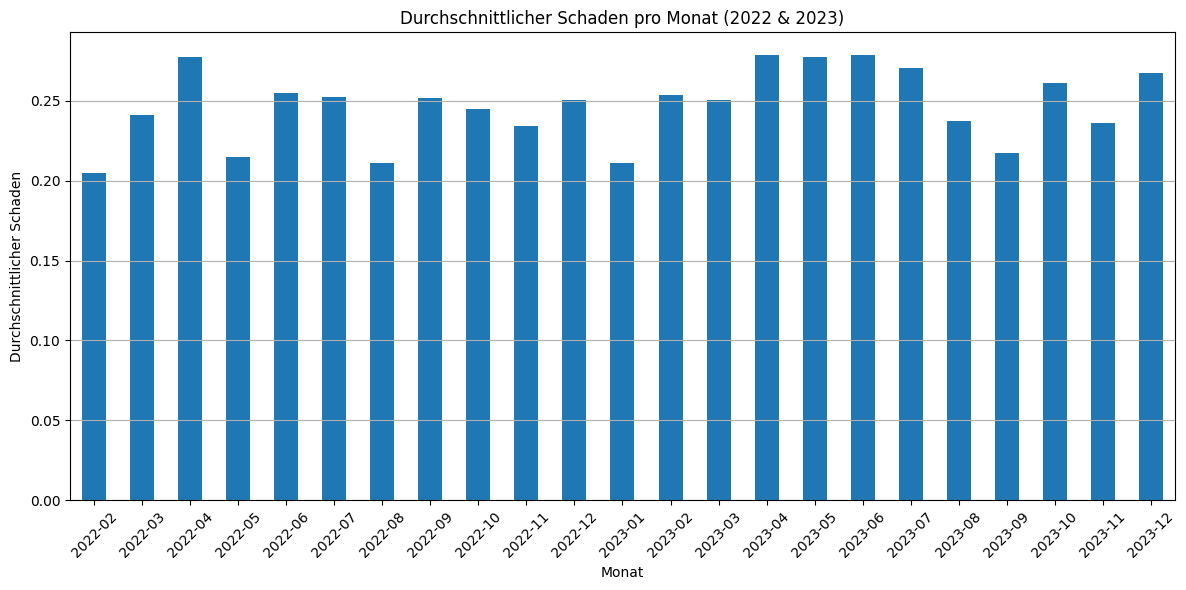

In [124]:
# Stelle sicher, dass 'transaction_start' ein datetime-Format hat
df_model_labeled['transaction_start'] = pd.to_datetime(df_model_labeled['transaction_start'])

# Filtere nur die Jahre 2022 und 2023
df_filtered = df_model_labeled[df_model_labeled['transaction_start'].dt.year.isin([2022, 2023])]

# Erstelle eine neue Spalte mit Jahr und Monat
df_filtered['year_month'] = df_filtered['transaction_start'].dt.to_period('M')

# Berechne den durchschnittlichen Schaden pro Monat
monthly_avg_damage = df_filtered.groupby('year_month')['damage'].mean()

# Zeichne ein Balkendiagramm
plt.figure(figsize=(12, 6))
monthly_avg_damage.plot(kind='bar')
plt.title('Durchschnittlicher Schaden pro Monat (2022 & 2023)')
plt.xlabel('Monat')
plt.ylabel('Durchschnittlicher Schaden')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [125]:
damage_mean = df_model_labeled[df_model_labeled['label'] == 'FRAUD']['damage'].mean()


In [126]:
print(damage_mean)

7.991661770877048


In [127]:
print(df_model_labeled)

                                          id                              store_id  cash_desk   transaction_start            transaction_end  total_amount  n_lines payment_medium  damage   label  sales_price_sum  sales_price_mean  sales_price_max  camera_certainty_mean  camera_certainty_min  was_voided_sum  category_nunique  sold_by_weight_sum  age_restricted_sum opening_date   location              state urbanization sco_introduction  has_snacks  has_beverages  has_frozen_goods  risky_category_score  transaction_duration_seconds  articles_per_minute  average_price_per_article  has_cash_payment  voided_articles_count  voided_articles_ratio  has_high_voided_ratio  low_camera_certainty_flag  hour  is_risky_hour  weekday  snack_count  max_category_count         dominant_category  has_dominant_category  dominant_is_snacks risky_score_bucket  is_suspiciously_risky_and_slow  label_binary
0       1e5e4083-6f6a-4277-918d-ebb253ff8869  664c9b33-0553-4050-9dff-5afc3aa3334b          2 2022-02-14 

In [128]:
# 1. Bedingung: FRAUD und damage > 5% von total_amount
condition = (df_model_labeled['label'] == 'FRAUD') & \
            (df_model_labeled['damage'] > 0.05 * df_model_labeled['total_amount'])

# 2. Anzahl der entsprechenden Fälle zählen
count = df_model_labeled[condition].shape[0]

# 3. Ausgabe
print("Anzahl der FRAUD-Fälle mit Schaden > 5% vom Einkaufswert:", count)

Anzahl der FRAUD-Fälle mit Schaden > 5% vom Einkaufswert: 3247


In [129]:
# Bedingung
condition = (df_model_labeled['label'] == 'FRAUD') & \
            (df_model_labeled['damage'] > 0.05 * df_model_labeled['total_amount'])

# Gefilterte Zeilen (DataFrame!)
damage_over_5pct = df_model_labeled[condition]

# Ausgabe der Zeilen
print(damage_over_5pct)


                                          id                              store_id  cash_desk   transaction_start            transaction_end  total_amount  n_lines payment_medium  damage  label  sales_price_sum  sales_price_mean  sales_price_max  camera_certainty_mean  camera_certainty_min  was_voided_sum  category_nunique  sold_by_weight_sum  age_restricted_sum opening_date   location              state urbanization sco_introduction  has_snacks  has_beverages  has_frozen_goods  risky_category_score  transaction_duration_seconds  articles_per_minute  average_price_per_article  has_cash_payment  voided_articles_count  voided_articles_ratio  has_high_voided_ratio  low_camera_certainty_flag  hour  is_risky_hour  weekday  snack_count  max_category_count         dominant_category  has_dominant_category  dominant_is_snacks risky_score_bucket  is_suspiciously_risky_and_slow  label_binary
146     0679c72e-bb52-47fe-b4ac-f00e239b6761  664c9b33-0553-4050-9dff-5afc3aa3334b          3 2022-02-21 2

In [130]:
damage_over_5pct


,id,store_id,cash_desk,transaction_start,transaction_end,total_amount,n_lines,payment_medium,damage,label,sales_price_sum,sales_price_mean,sales_price_max,camera_certainty_mean,camera_certainty_min,was_voided_sum,category_nunique,sold_by_weight_sum,age_restricted_sum,opening_date,location,state,urbanization,sco_introduction,has_snacks,has_beverages,has_frozen_goods,risky_category_score,transaction_duration_seconds,articles_per_minute,average_price_per_article,has_cash_payment,voided_articles_count,voided_articles_ratio,has_high_voided_ratio,low_camera_certainty_flag,hour,is_risky_hour,weekday,snack_count,max_category_count,dominant_category,has_dominant_category,dominant_is_snacks,risky_score_bucket,is_suspiciously_risky_and_slow,label_binary
146,0679c72e-bb52-47fe-b4ac-f00e239b6761,664c9b33-0553-4050-9dff-5afc3aa3334b,3,2022-02-21 20:40:45,2022-02-21 20:41:21.665778,79.07,8,CREDIT_CARD,23.57,FRAUD,79.07,9.883750,35.26,0.336263,0.261288,0,4,0,0,2006-06-19,Karlsruhe,Baden-Württemberg,TOWNS,2022-02-13,0,0,1,1,36.665778,13.09,9.88,0,0,0.000,0,0,20,1,0,0,5,LONG_SHELF_LIFE,0,0,1,0,1
161,38ab96bc-96ee-4f6a-8d22-e67d7087d83e,664c9b33-0553-4050-9dff-5afc3aa3334b,3,2022-02-23 13:35:09,2022-02-23 13:35:24.436981,2.61,1,CREDIT_CARD,2.78,FRAUD,2.61,2.610000,2.61,0.996570,0.996570,0,1,0,0,2006-06-19,Karlsruhe,Baden-Württemberg,TOWNS,2022-02-13,0,0,0,0,15.436981,3.89,2.61,0,0,0.000,0,0,13,0,2,0,1,FRUITS_VEGETABLES_PIECES,0,0,0,0,1
247,97683ec6-a2a2-4312-a1a0-d466f739e82b,664c9b33-0553-4050-9dff-5afc3aa3334b,3,2022-02-28 08:25:24,2022-02-28 08:26:29.887728,38.09,7,CREDIT_CARD,8.36,FRAUD,38.09,5.441429,19.50,0.787376,0.414728,0,3,0,0,2006-06-19,Karlsruhe,Baden-Württemberg,TOWNS,2022-02-13,0,1,1,3,65.887728,6.37,5.44,0,0,0.000,0,0,8,0,0,0,5,FRUITS_VEGETABLES_PIECES,0,0,3,0,1
316,a07cc76e-058c-4ddd-9d18-19df5eb08a49,664c9b33-0553-4050-9dff-5afc3aa3334b,3,2022-03-04 10:22:39,2022-03-04 10:22:52.715194,1.39,1,CREDIT_CARD,0.59,FRAUD,1.39,1.390000,1.39,0.844613,0.844613,0,1,0,0,2006-06-19,Karlsruhe,Baden-Württemberg,TOWNS,2022-02-13,0,1,0,2,13.715194,4.37,1.39,0,0,0.000,0,0,10,0,4,0,1,BEVERAGES,0,0,2,0,1
328,e97a2a2f-788f-4509-b583-edd37c30d4bf,664c9b33-0553-4050-9dff-5afc3aa3334b,3,2022-03-04 17:29:39,2022-03-04 17:30:02.051954,14.92,4,CREDIT_CARD,3.61,FRAUD,14.92,3.730000,6.24,0.957104,0.914229,0,2,0,0,2006-06-19,Karlsruhe,Baden-Württemberg,TOWNS,2022-02-13,0,1,0,2,23.051954,10.41,3.73,0,0,0.000,0,0,17,0,4,0,3,BEVERAGES,0,0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152912,608df405-e6bb-49d8-be6f-69f1e2196bdd,9aaa4004-eacd-425d-89ac-5e3d64dc9426,2,2023-12-22 20:08:54,2023-12-22 20:09:14.926443,1.96,1,CASH,13.60,FRAUD,1.96,1.960000,1.96,1.000000,1.000000,0,1,0,0,2002-02-01,Osnabrück,Niedersachsen,CITIES,2022-02-05,1,0,0,3,20.926443,2.87,1.96,1,0,0.000,0,0,20,1,4,1,1,SNACKS,0,1,3,0,1
152916,529f0e14-e89c-471a-8ba7-fbe4df0d5c45,9aaa4004-eacd-425d-89ac-5e3d64dc9426,0,2023-12-22 21:15:03,2023-12-22 21:15:18.683084,7.84,1,CASH,23.70,FRAUD,7.84,7.840000,7.84,0.902616,0.902616,0,1,0,0,2002-02-01,Osnabrück,Niedersachsen,CITIES,2022-02-05,1,0,0,3,15.683084,3.83,7.84,1,0,0.000,0,0,21,1,4,1,1,SNACKS,0,1,3,0,1
153021,d661e3fc-b0f5-4df3-90f2-6783ea4dfab9,9aaa4004-eacd-425d-89ac-5e3d64dc9426,2,2023-12-29 13:38:18,2023-12-29 13:39:46.769135,57.18,12,CASH,7.20,FRAUD,57.18,4.765000,24.75,0.980062,0.929871,0,2,0,0,2002-02-01,Osnabrück,Niedersachsen,CITIES,2022-02-05,0,1,0,2,88.769135,8.11,4.76,1,0,0.000,0,0,13,0,4,0,7,FRUITS_VEGETABLES_PIECES,0,0,2,0,1
153058,769145d6-01e7-4d32-ba13-7bd7b4989191,9aaa4004-eacd-425d-89ac-5e3d64dc9426,1,2023-12-30 13:07:30,2023-12-30 13:08:09.608200,57.01,6,CREDIT_CARD,21.51,FRAUD,57.01,8.144286,22.77,0.989741,0.928187,1,3,0,0,2002-02-01,Osnabrück,Niedersachsen,CITIES,2022-02-05,0,1,1,3,39.608200,9.09,9.50,0,1,0.167,1,0,13,0,5,0,5,BEVERAGES,0,0,3,0,1


In [131]:
print((df_model_labeled['label'] == 'FRAUD').sum())


4766


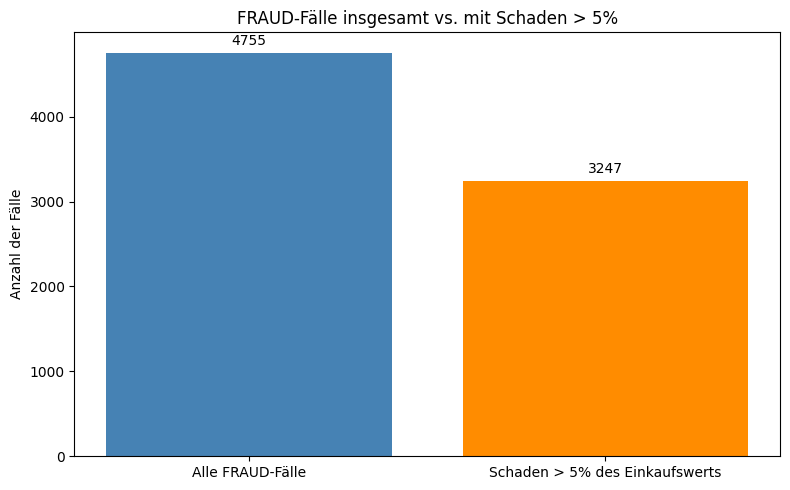

In [132]:
# Werte definieren
total_fraud = 4755
damage_over_5pct = 3247

# Balkendiagramm
labels = ['Alle FRAUD-Fälle', 'Schaden > 5% des Einkaufswerts']
values = [total_fraud, damage_over_5pct]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values, color=['steelblue', 'darkorange'])

# Werte als Text anzeigen
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, f'{yval}', ha='center', va='bottom')

plt.ylabel('Anzahl der Fälle')
plt.title('FRAUD-Fälle insgesamt vs. mit Schaden > 5%')
plt.tight_layout()
plt.show()

In [133]:
print(damage_over_5pct)

3247


In [134]:
print(df_model_labeled)

                                          id                              store_id  cash_desk   transaction_start            transaction_end  total_amount  n_lines payment_medium  damage   label  sales_price_sum  sales_price_mean  sales_price_max  camera_certainty_mean  camera_certainty_min  was_voided_sum  category_nunique  sold_by_weight_sum  age_restricted_sum opening_date   location              state urbanization sco_introduction  has_snacks  has_beverages  has_frozen_goods  risky_category_score  transaction_duration_seconds  articles_per_minute  average_price_per_article  has_cash_payment  voided_articles_count  voided_articles_ratio  has_high_voided_ratio  low_camera_certainty_flag  hour  is_risky_hour  weekday  snack_count  max_category_count         dominant_category  has_dominant_category  dominant_is_snacks risky_score_bucket  is_suspiciously_risky_and_slow  label_binary
0       1e5e4083-6f6a-4277-918d-ebb253ff8869  664c9b33-0553-4050-9dff-5afc3aa3334b          2 2022-02-14 

MODELL TRAINING

In [135]:
#df_model_labeled.to_csv("df_model_labeled.csv", index=False)


In [136]:
fraud_cases = df_model_labeled[df_model_labeled['label'] == 'FRAUD']
print(fraud_cases)


                                          id                              store_id  cash_desk   transaction_start            transaction_end  total_amount  n_lines payment_medium  damage  label  sales_price_sum  sales_price_mean  sales_price_max  camera_certainty_mean  camera_certainty_min  was_voided_sum  category_nunique  sold_by_weight_sum  age_restricted_sum opening_date   location              state urbanization sco_introduction  has_snacks  has_beverages  has_frozen_goods  risky_category_score  transaction_duration_seconds  articles_per_minute  average_price_per_article  has_cash_payment  voided_articles_count  voided_articles_ratio  has_high_voided_ratio  low_camera_certainty_flag  hour  is_risky_hour  weekday  snack_count  max_category_count         dominant_category  has_dominant_category  dominant_is_snacks risky_score_bucket  is_suspiciously_risky_and_slow  label_binary
146     0679c72e-bb52-47fe-b4ac-f00e239b6761  664c9b33-0553-4050-9dff-5afc3aa3334b          3 2022-02-21 2

In [137]:
print(fraud_cases[['total_amount', 'damage', 'label']])


        total_amount  damage  label
146            79.07   23.57  FRAUD
157           342.22    3.41  FRAUD
161             2.61    2.78  FRAUD
247            38.09    8.36  FRAUD
316             1.39    0.59  FRAUD
...              ...     ...    ...
152916          7.84   23.70  FRAUD
153021         57.18    7.20  FRAUD
153058         57.01   21.51  FRAUD
153076         69.72   13.60  FRAUD
153081        108.10    5.09  FRAUD

[4766 rows x 3 columns]


In [138]:
suspicious = fraud_cases[fraud_cases['damage'] > fraud_cases['total_amount']]
print(suspicious)

                                          id                              store_id  cash_desk   transaction_start            transaction_end  total_amount  n_lines payment_medium  damage  label  sales_price_sum  sales_price_mean  sales_price_max  camera_certainty_mean  camera_certainty_min  was_voided_sum  category_nunique  sold_by_weight_sum  age_restricted_sum opening_date   location              state urbanization sco_introduction  has_snacks  has_beverages  has_frozen_goods  risky_category_score  transaction_duration_seconds  articles_per_minute  average_price_per_article  has_cash_payment  voided_articles_count  voided_articles_ratio  has_high_voided_ratio  low_camera_certainty_flag  hour  is_risky_hour  weekday  snack_count  max_category_count         dominant_category  has_dominant_category  dominant_is_snacks risky_score_bucket  is_suspiciously_risky_and_slow  label_binary
161     38ab96bc-96ee-4f6a-8d22-e67d7087d83e  664c9b33-0553-4050-9dff-5afc3aa3334b          3 2022-02-23 1

In [139]:
df_model_labeled.columns.tolist()


['id',
 'store_id',
 'cash_desk',
 'transaction_start',
 'transaction_end',
 'total_amount',
 'n_lines',
 'payment_medium',
 'damage',
 'label',
 'sales_price_sum',
 'sales_price_mean',
 'sales_price_max',
 'camera_certainty_mean',
 'camera_certainty_min',
 'was_voided_sum',
 'category_nunique',
 'sold_by_weight_sum',
 'age_restricted_sum',
 'opening_date',
 'location',
 'state',
 'urbanization',
 'sco_introduction',
 'has_snacks',
 'has_beverages',
 'has_frozen_goods',
 'risky_category_score',
 'transaction_duration_seconds',
 'articles_per_minute',
 'average_price_per_article',
 'has_cash_payment',
 'voided_articles_count',
 'voided_articles_ratio',
 'has_high_voided_ratio',
 'low_camera_certainty_flag',
 'hour',
 'is_risky_hour',
 'weekday',
 'snack_count',
 'max_category_count',
 'dominant_category',
 'has_dominant_category',
 'dominant_is_snacks',
 'risky_score_bucket',
 'is_suspiciously_risky_and_slow',
 'label_binary']

In [140]:
df_model_labeled['label_fraud5_bin'] = (
    (df_model_labeled['label'] == 'FRAUD') &
    (df_model_labeled['damage'] > 0.05 * df_model_labeled['total_amount'])
).astype(int)


In [141]:
df = df_model_labeled.copy()


In [142]:
# Liste deiner verdächtigen Spalten (manuell ergänzt)
leak_check_cols = [
    'damage', 'payment_medium', 'label',
    'id', 'store_id', 'cash_desk', 'transaction_start', 'transaction_end',
    'total_amount', 'sales_price_sum', 'sales_price_mean', 'sales_price_max',
    'camera_certainty_mean', 'camera_certainty_min', 'was_voided_sum',
    'category_nunique', 'sold_by_weight_sum', 'age_restricted_sum',
    'opening_date', 'location', 'state', 'urbanization', 'sco_introduction',
    'has_snacks', 'has_beverages', 'has_frozen_goods', 'risky_category_score',
    'transaction_duration_seconds', 'articles_per_minute', 'average_price_per_article',
    'has_cash_payment', 'voided_articles_count', 'voided_articles_ratio',
    'has_high_voided_ratio', 'low_camera_certainty_flag', 'hour', 'is_risky_hour',
    'weekday', 'snack_count', 'max_category_count', 'dominant_category',
    'has_dominant_category', 'dominant_is_snacks', 'risky_score_bucket',
    'is_suspiciously_risky_and_slow', 'label_binary'
]

# Prüfen, ob eine Spalte nur bei Fraud (label_fraud5_bin == 1) oder Normal (== 0) gefüllt ist
for col in leak_check_cols:
    nulls_fraud = df.loc[df['label_fraud5_bin'] == 1, col].isna().mean()
    nulls_normal = df.loc[df['label_fraud5_bin'] == 0, col].isna().mean()
    print(f"{col:<35} | NA% bei FRAUD: {nulls_fraud:.2f} | NA% bei NORMAL: {nulls_normal:.2f}")


damage                              | NA% bei FRAUD: 0.00 | NA% bei NORMAL: 0.00
payment_medium                      | NA% bei FRAUD: 0.00 | NA% bei NORMAL: 0.00
label                               | NA% bei FRAUD: 0.00 | NA% bei NORMAL: 0.00
id                                  | NA% bei FRAUD: 0.00 | NA% bei NORMAL: 0.00
store_id                            | NA% bei FRAUD: 0.00 | NA% bei NORMAL: 0.00
cash_desk                           | NA% bei FRAUD: 0.00 | NA% bei NORMAL: 0.00
transaction_start                   | NA% bei FRAUD: 0.00 | NA% bei NORMAL: 0.00
transaction_end                     | NA% bei FRAUD: 0.00 | NA% bei NORMAL: 0.00
total_amount                        | NA% bei FRAUD: 0.00 | NA% bei NORMAL: 0.00
sales_price_sum                     | NA% bei FRAUD: 0.00 | NA% bei NORMAL: 0.00
sales_price_mean                    | NA% bei FRAUD: 0.00 | NA% bei NORMAL: 0.00
sales_price_max                     | NA% bei FRAUD: 0.00 | NA% bei NORMAL: 0.00
camera_certainty_mean       

In [143]:
df_corr = df_model_labeled.copy()
df_corr['label_fraud5_bin'] = (
    (df_corr['label'] == 'FRAUD') & 
    (df_corr['damage'] > 0.05 * df_corr['total_amount'])
).astype(int)

correlation_with_label = (
    df_corr.select_dtypes(include='number')
    .corr()['label_fraud5_bin']
    .sort_values(key=abs, ascending=False)
)

correlation_with_label.drop('label_fraud5_bin').head(10)


label_binary          0.821205
damage                0.704042
dominant_is_snacks    0.279346
has_cash_payment      0.272379
has_snacks            0.076609
snack_count           0.072260
sales_price_max      -0.065623
sales_price_sum      -0.059124
total_amount         -0.058776
sales_price_mean     -0.052739
Name: label_fraud5_bin, dtype: float64

In [144]:
# Neues DataFrame ohne echte Leaks (aber mit total_amount behalten)
df_model_cleaned = df_model_labeled.drop(columns=['label_binary', 'damage'])

# Zielspalte direkt mit rein – dafür weiterhin damage für Label-Berechnung verwenden
df_model_cleaned['label_fraud5_bin'] = (
    (df_model_labeled['label'] == 'FRAUD') &
    (df_model_labeled['damage'] > 0.05 * df_model_labeled['total_amount'])
).astype(int)

# Speichern für Colab
df_model_cleaned.to_csv("df_model_cleaned.csv", index=False)


In [145]:
# 1. Anteil Snacks am Gesamtwert
df_model_cleaned['snack_share'] = df_model_cleaned['snack_count'] / (df_model_cleaned['n_lines'] + 1e-5)

# 2. Risk per Second: risk_score im Verhältnis zur Dauer
df_model_cleaned['risk_per_second'] = df_model_cleaned['risky_category_score'] / (df_model_cleaned['transaction_duration_seconds'] + 1e-5)

# 3. Suspicious Combo: Wenn riskant, schnell, mit Barzahlung & viel storniert
df_model_cleaned['is_suspicious_combo'] = (
    df_model_cleaned['has_cash_payment'] &
    df_model_cleaned['is_risky_hour'] &
    (df_model_cleaned['voided_articles_ratio'] > 0.3)
).astype(int)

# 4. Durchschnittlicher Preis der stornierten Artikel
df_model_cleaned['avg_voided_price'] = (
    df_model_cleaned['voided_articles_count'] * df_model_cleaned['sales_price_mean']
) / (df_model_cleaned['voided_articles_count'] + 1e-5)

# 5. Kategorienstreuung (Verhältnis Anzahl Kategorien zu Artikeln)
df_model_cleaned['category_diversity_ratio'] = df_model_cleaned['category_nunique'] / (df_model_cleaned['n_lines'] + 1e-5)


In [146]:
neue_features = [
    'snack_share',
    'risk_per_second',
    'is_suspicious_combo',
    'avg_voided_price',
    'category_diversity_ratio'
]

correlations = df_model_cleaned[neue_features + ['label_fraud5_bin']].corr()['label_fraud5_bin'].sort_values(key=abs, ascending=False)

print("📊 Korrelation mit label_fraud5_bin:")
print(correlations.drop('label_fraud5_bin'))


📊 Korrelation mit label_fraud5_bin:
snack_share                 0.258467
risk_per_second             0.069557
is_suspicious_combo         0.059834
category_diversity_ratio    0.038851
avg_voided_price           -0.002112
Name: label_fraud5_bin, dtype: float64


In [147]:
# Neues sauberes DataFrame (nur echte Leaks raus!)
df_model_cleaned = df_model_labeled.drop(columns=['label_binary', 'damage'])


In [148]:
# Zielspalte definieren (weiterhin basierend auf 'damage', das aber NICHT ins Modell kommt)
df_model_cleaned['label_fraud5_bin'] = (
    (df_model_labeled['label'] == 'FRAUD') &
    (df_model_labeled['damage'] > 0.05 * df_model_labeled['total_amount'])
).astype(int)

# 🧠 Feature 1: Anteil Snacks pro Artikel
df_model_cleaned['snack_share'] = df_model_cleaned['snack_count'] / (df_model_cleaned['n_lines'] + 1e-5)

# 🧠 Feature 2: Risk per Second
df_model_cleaned['risk_per_second'] = df_model_cleaned['risky_category_score'] / (df_model_cleaned['transaction_duration_seconds'] + 1e-5)

# 🧠 Feature 3: Suspicious Combo
df_model_cleaned['is_suspicious_combo'] = (
    df_model_cleaned['has_cash_payment'] &
    df_model_cleaned['is_risky_hour'] &
    (df_model_cleaned['voided_articles_ratio'] > 0.3)
).astype(int)

# Speichern für Colab
df_model_cleaned.to_csv("df_model_cleaned.csv", index=False)

In [149]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np


In [150]:
df_model_cleaned['label_fraud_bin'] = (df_model_cleaned['label'] == 'FRAUD').astype(int)


In [151]:
# 🎯 Zielspalte (für dieses Modell)
y = df_model_cleaned['label_fraud_bin']

# ❌ Leak-Spalten ausschließen
leak_columns = {
    'label',
    'label_fraud5_bin',
    'label_fraud_bin',   # Zielvariable – nicht in X!
}


In [152]:
# 🧠 Nur numerische Spalten – ohne Leaks
features = df_model_cleaned.select_dtypes(include='number').columns.difference(leak_columns)

# Feature-Matrix
X = df_model_cleaned[features].fillna(df_model_cleaned[features].median())

# Train/Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 📏 XGBoost mit Gewichtung wegen Imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# 🏋️‍♂️ Trainieren
xgb.fit(X_train, y_train)

c:\Users\felix\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:09:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [153]:
# 📊 Vorhersage mit Schwellenwertoptimierung
y_proba = xgb.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
target_precision = 0.85
mask = precision[:-1] >= target_precision

if any(mask):
    idx = np.argmax(recall[:-1][mask])
    best_threshold = thresholds[mask][idx]
else:
    best_threshold = 0.5

y_pred = (y_proba >= best_threshold).astype(int)

# 🧾 Auswertung
print(f"\n✅ Verwendeter Threshold: {best_threshold:.6f}")
print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\n📈 Klassifikationsbericht:")
print(classification_report(y_test, y_pred, digits=3))


✅ Verwendeter Threshold: 0.978380

📊 Confusion Matrix:
[[29639    25]
 [  808   145]]

📈 Klassifikationsbericht:
              precision    recall  f1-score   support

           0      0.973     0.999     0.986     29664
           1      0.853     0.152     0.258       953

    accuracy                          0.973     30617
   macro avg      0.913     0.576     0.622     30617
weighted avg      0.970     0.973     0.963     30617



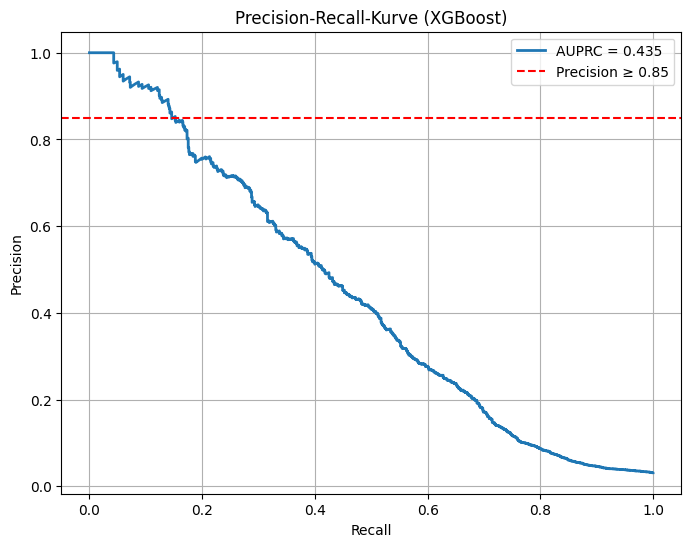

In [154]:
# 📈 PR-Kurve
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUPRC = {pr_auc:.3f}', linewidth=2)
plt.title('Precision-Recall-Kurve (XGBoost)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.axhline(0.85, color='red', linestyle='--', label='Precision ≥ 0.85')
plt.legend()
plt.show()

In [155]:
df_temp = df_model_cleaned.copy()

In [156]:
# 1. Voids pro Minute
df_temp['voids_per_minute'] = df_temp['voided_articles_count'] / (df_temp['transaction_duration_seconds'] + 1e-5)

# 2. Snack-Dichte (Snacks pro Sekunde)
df_temp['snack_density'] = df_temp['snack_count'] / (df_temp['transaction_duration_seconds'] + 1e-5)

# 3. Teure Positionen enthalten (Maxpreis > 20€)
df_temp['expensive_items_flag'] = (df_temp['sales_price_max'] > 20).astype(int)

# 4. Storno bei risikoreicher Stunde
df_temp['voids_risky_hour'] = ((df_temp['voided_articles_ratio'] > 0.3) & df_temp['is_risky_hour']).astype(int)

# 5. Kategorie-Diversität pro Artikel
df_temp['category_diversity_per_line'] = df_temp['category_nunique'] / (df_temp['n_lines'] + 1e-5)

# 6. Risiko pro Artikel
df_temp['risky_score_per_line'] = df_temp['risky_category_score'] / (df_temp['n_lines'] + 1e-5)

# 7. Voids im Verhältnis zur gesamten Summe
df_temp['void_value_ratio'] = df_temp['was_voided_sum'] / (df_temp['sales_price_sum'] + 1e-5)

# 8. Abbruch-Geschwindigkeit (n_lines / Dauer)
df_temp['lines_per_second'] = df_temp['n_lines'] / (df_temp['transaction_duration_seconds'] + 1e-5)

# 9. Sehr kurze Transaktion (<10s)
df_temp['is_very_fast'] = (df_temp['transaction_duration_seconds'] < 10).astype(int)

# 10. Kombi aus fast & storniert
df_temp['fast_void_combo'] = (
    (df_temp['transaction_duration_seconds'] < 20) &
    (df_temp['voided_articles_ratio'] > 0.3)
).astype(int)

# 11. Risiko-Multiplikation mit Uhrzeit
df_temp['risky_hour_score'] = df_temp['risky_category_score'] * df_temp['is_risky_hour']

# 12. Artikel-Menge pro Minute
df_temp['articles_per_minute_alt'] = df_temp['n_lines'] / ((df_temp['transaction_duration_seconds'] / 60) + 1e-5)

# 13. Hoher Durchschnittspreis (über 10 €)
df_temp['avg_price_over_10'] = (df_temp['average_price_per_article'] > 10).astype(int)

# 14. Stornierungs-Intensität (Ratio * Artikelanzahl)
df_temp['void_intensity'] = df_temp['voided_articles_ratio'] * df_temp['n_lines']

# 15. Leere Transaktion (Summe < 1 €)
df_temp['almost_empty'] = (df_temp['sales_price_sum'] < 1).astype(int)



In [157]:
correlations = df_temp[[
    'voids_per_minute', 'snack_density', 'expensive_items_flag',
    'voids_risky_hour', 'category_diversity_per_line', 'risky_score_per_line',
    'void_value_ratio', 'lines_per_second', 'is_very_fast', 'fast_void_combo',
    'risky_hour_score', 'articles_per_minute_alt', 'avg_price_over_10',
    'void_intensity', 'almost_empty'
]].corrwith(df_temp['label_fraud_bin'])

print("📊 Korrelationen mit label_fraud_bin:")
print(correlations.sort_values(ascending=False))


📊 Korrelationen mit label_fraud_bin:
snack_density                  0.177452
risky_hour_score               0.046267
void_value_ratio               0.031883
category_diversity_per_line    0.031881
almost_empty                   0.029426
void_intensity                 0.026933
voids_per_minute               0.025294
voids_risky_hour               0.023475
risky_score_per_line           0.020198
is_very_fast                   0.004550
fast_void_combo               -0.000346
articles_per_minute_alt       -0.008827
lines_per_second              -0.008828
expensive_items_flag          -0.014768
avg_price_over_10             -0.029170
dtype: float64


In [158]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 🔁 Arbeitskopie erstellen
df_ready = df_model_cleaned.copy()

# ✅ 1. 'payment_medium' in numerisch umwandeln (falls nötig)
if df_ready['payment_medium'].dtype == 'object':
    le = LabelEncoder()
    df_ready['payment_medium'] = le.fit_transform(df_ready['payment_medium'])

# ❌ 2. Spalten entfernen, die zu Leaks oder nicht modellgeeignet sind
leak_or_irrelevant_cols = [
    'label',               # Original-Label
    'label_fraud5_bin',    # Ableitung
    'id',
    'store_id',            # nicht hilfreich, kann leaken
    'transaction_start', 'transaction_end', 'opening_date',
    'location', 'state', 'urbanization',
    'dominant_category'    # kategorisch
]

# Entfernen – aber nur, wenn Spalten auch wirklich vorhanden sind
leak_or_irrelevant_cols = [col for col in leak_or_irrelevant_cols if col in df_ready.columns]

# Anwenden
df_ready = df_ready.drop(columns=leak_or_irrelevant_cols)

# 💾 Speichern – Zielspalte 'label_fraud_bin' bleibt enthalten!
df_ready.to_csv("df_ready_for_tpot.csv", index=False)


In [159]:
df_ready['payment_medium'].value_counts()



payment_medium
1    137572
0     15512
Name: count, dtype: int64

In [160]:
# Zeig alle verbleibenden Spalten
print("✅ Verbleibende Spalten für TPOT:")
print(df_ready.columns.tolist())


✅ Verbleibende Spalten für TPOT:
['cash_desk', 'total_amount', 'n_lines', 'payment_medium', 'sales_price_sum', 'sales_price_mean', 'sales_price_max', 'camera_certainty_mean', 'camera_certainty_min', 'was_voided_sum', 'category_nunique', 'sold_by_weight_sum', 'age_restricted_sum', 'sco_introduction', 'has_snacks', 'has_beverages', 'has_frozen_goods', 'risky_category_score', 'transaction_duration_seconds', 'articles_per_minute', 'average_price_per_article', 'has_cash_payment', 'voided_articles_count', 'voided_articles_ratio', 'has_high_voided_ratio', 'low_camera_certainty_flag', 'hour', 'is_risky_hour', 'weekday', 'snack_count', 'max_category_count', 'has_dominant_category', 'dominant_is_snacks', 'risky_score_bucket', 'is_suspiciously_risky_and_slow', 'snack_share', 'risk_per_second', 'is_suspicious_combo', 'label_fraud_bin']


In [161]:
df_ready.to_csv("df_ready_for_tpot.csv", index=False)


In [162]:
df_ready

,cash_desk,total_amount,n_lines,payment_medium,sales_price_sum,sales_price_mean,sales_price_max,camera_certainty_mean,camera_certainty_min,was_voided_sum,category_nunique,sold_by_weight_sum,age_restricted_sum,sco_introduction,has_snacks,has_beverages,has_frozen_goods,risky_category_score,transaction_duration_seconds,articles_per_minute,average_price_per_article,has_cash_payment,voided_articles_count,voided_articles_ratio,has_high_voided_ratio,low_camera_certainty_flag,hour,is_risky_hour,weekday,snack_count,max_category_count,has_dominant_category,dominant_is_snacks,risky_score_bucket,is_suspiciously_risky_and_slow,snack_share,risk_per_second,is_suspicious_combo,label_fraud_bin
0,2,96.57,14,1,96.57,6.897857,32.39,0.274696,0.185360,0,4,0,0,2022-02-13,0,1,1,3,68.819448,12.21,6.90,0,0,0.0,0,1,8,0,0,0,6,0,0,3,0,0.0,0.043592,0,0
1,3,57.66,6,1,57.66,9.610000,34.11,0.281571,0.267869,0,3,0,0,2022-02-13,0,1,1,3,43.679465,8.24,9.61,0,0,0.0,0,0,8,0,0,0,3,0,0,3,0,0.0,0.068682,0,0
2,1,12.20,3,1,12.20,4.066667,8.19,0.288782,0.281739,0,2,0,0,2022-02-13,0,1,0,2,30.023526,6.00,4.07,0,0,0.0,0,0,8,0,0,0,2,0,0,2,0,0.0,0.066614,0,0
3,2,41.34,3,1,41.34,13.780000,25.02,0.296226,0.267349,0,2,0,0,2022-02-13,0,1,0,2,27.613637,6.52,13.78,0,0,0.0,0,0,9,0,0,0,2,0,0,2,0,0.0,0.072428,0,0
4,3,57.41,6,1,57.41,9.568333,23.22,0.266609,0.228188,0,2,0,0,2022-02-13,0,0,1,1,50.716049,7.10,9.57,0,0,0.0,0,1,9,0,0,0,4,0,0,1,0,0.0,0.019718,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153079,1,18.81,1,1,18.81,18.810000,18.81,0.949700,0.949700,0,1,0,0,2022-02-05,0,0,0,0,11.487445,5.22,18.81,0,0,0.0,0,0,20,1,5,0,1,0,0,0,0,0.0,0.000000,0,0
153080,3,110.68,13,1,110.68,8.513846,39.51,0.967769,0.864739,0,4,0,0,2022-02-05,0,1,1,3,104.231479,7.48,8.51,0,0,0.0,0,0,20,1,5,0,7,0,0,3,0,0.0,0.028782,0,0
153081,0,108.10,11,1,108.10,9.827273,41.28,0.919647,0.769568,0,2,0,0,2022-02-05,0,1,0,2,103.021139,6.41,9.83,0,0,0.0,0,0,21,1,5,0,7,0,0,2,0,0.0,0.019413,0,1
153082,2,172.42,33,1,172.42,5.224848,23.84,0.976974,0.815211,0,3,0,0,2022-02-05,0,1,1,3,197.383811,10.03,5.22,0,0,0.0,0,0,21,1,5,0,16,1,0,3,0,0.0,0.015199,0,0


In [163]:
print(df_ready.dtypes)

cash_desk                            int64
total_amount                       float64
n_lines                              int64
payment_medium                       int32
sales_price_sum                    float64
sales_price_mean                   float64
sales_price_max                    float64
camera_certainty_mean              float64
camera_certainty_min               float64
was_voided_sum                       int64
category_nunique                     int64
sold_by_weight_sum                   int64
age_restricted_sum                   int64
sco_introduction                    object
has_snacks                           int32
has_beverages                        int32
has_frozen_goods                     int32
risky_category_score                 int32
transaction_duration_seconds       float64
articles_per_minute                float64
average_price_per_article          float64
has_cash_payment                     int32
voided_articles_count                int32
voided_arti

In [164]:
df_ready = df_ready.drop(columns=['sco_introduction'])


In [165]:
df_ready.dtypes


cash_desk                            int64
total_amount                       float64
n_lines                              int64
payment_medium                       int32
sales_price_sum                    float64
sales_price_mean                   float64
sales_price_max                    float64
camera_certainty_mean              float64
camera_certainty_min               float64
was_voided_sum                       int64
category_nunique                     int64
sold_by_weight_sum                   int64
age_restricted_sum                   int64
has_snacks                           int32
has_beverages                        int32
has_frozen_goods                     int32
risky_category_score                 int32
transaction_duration_seconds       float64
articles_per_minute                float64
average_price_per_article          float64
has_cash_payment                     int32
voided_articles_count                int32
voided_articles_ratio              float64
has_high_vo

In [166]:
df_ready['risky_score_bucket'] = df['risky_score_bucket'].replace('4+', 4).astype(int)


C:\Users\felix\AppData\Local\Temp\ipykernel_12340\279946713.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_ready['risky_score_bucket'] = df['risky_score_bucket'].replace('4+', 4).astype(int)


In [167]:
df_ready.to_csv("df_ready.csv", index=False)

In [168]:
# Wähle die ersten 5000 Zeilen aus
df_5000 = df_ready.head(5000)

In [169]:
# Speichere sie in eine neue CSV-Datei
df_5000.to_csv("erste_5000_zeilen.csv", index=False)

In [170]:
df_model_cleaned[
    (df_model_cleaned['total_amount'] == 14.11) &
    (df_model_cleaned['id'] == '7077f013-3927-4d40-9799-f18c4bc18085')
]

,id,store_id,cash_desk,transaction_start,transaction_end,total_amount,n_lines,payment_medium,label,sales_price_sum,sales_price_mean,sales_price_max,camera_certainty_mean,camera_certainty_min,was_voided_sum,category_nunique,sold_by_weight_sum,age_restricted_sum,opening_date,location,state,urbanization,sco_introduction,has_snacks,has_beverages,has_frozen_goods,risky_category_score,transaction_duration_seconds,articles_per_minute,average_price_per_article,has_cash_payment,voided_articles_count,voided_articles_ratio,has_high_voided_ratio,low_camera_certainty_flag,hour,is_risky_hour,weekday,snack_count,max_category_count,dominant_category,has_dominant_category,dominant_is_snacks,risky_score_bucket,is_suspiciously_risky_and_slow,label_fraud5_bin,snack_share,risk_per_second,is_suspicious_combo,label_fraud_bin
148061,7077f013-3927-4d40-9799-f18c4bc18085,9aaa4004-eacd-425d-89ac-5e3d64dc9426,0,2023-03-31 09:17:12,2023-03-31 09:17:40.796472,14.11,2,CREDIT_CARD,NORMAL,14.11,7.055,7.16,0.950309,0.900617,0,1,0,0,2002-02-01,Osnabrück,Niedersachsen,CITIES,2022-02-05,0,0,0,0,28.796472,4.17,7.06,0,0,0.0,0,0,9,0,4,0,2,FRUITS_VEGETABLES_PIECES,0,0,0,0,0,0.0,0.0,0,0


In [171]:
print(df_ready.columns)

Index(['cash_desk', 'total_amount', 'n_lines', 'payment_medium',
       'sales_price_sum', 'sales_price_mean', 'sales_price_max',
       'camera_certainty_mean', 'camera_certainty_min', 'was_voided_sum',
       'category_nunique', 'sold_by_weight_sum', 'age_restricted_sum',
       'has_snacks', 'has_beverages', 'has_frozen_goods',
       'risky_category_score', 'transaction_duration_seconds',
       'articles_per_minute', 'average_price_per_article', 'has_cash_payment',
       'voided_articles_count', 'voided_articles_ratio',
       'has_high_voided_ratio', 'low_camera_certainty_flag', 'hour',
       'is_risky_hour', 'weekday', 'snack_count', 'max_category_count',
       'has_dominant_category', 'dominant_is_snacks', 'risky_score_bucket',
       'is_suspiciously_risky_and_slow', 'snack_share', 'risk_per_second',
       'is_suspicious_combo', 'label_fraud_bin'],
      dtype='object')
